# Queshque Glacier Simulation with Frontal Ablation
### Outline:
##### 1] Create OGGM Glacier Directory for QQ at 10m resolution (as opposed to 28)
##### 2] Calibrate Mass Balance Model using Standard OGGM approach (but using Jan as starting month)
##### 3] Calibrate initial ice thickness and Glen's A using 2014 GPR *bed topo* data, evaluate ice thickness against 2009 GPR
***Needs to be re-run once I have lake bathymetry. Lake depth is sensitive to min_slope param ***
Have mostly completed up to this step. Calibrated using epoch 2 survey and validated against reserved epoch 2 data as well as epoch 1. Results are highly accurate, with average acuracy within 20cm (!) of epoch 1 survey data, despite larger local error. This is a great result.
Initial conditions uncertainty has been highly reduced by using the extensive epoch 2 survey to find creep paramter range.
Next: Prepare model for calving experiments by inverting ice thickness using using calibrated A_opt.
##### 4] Calibrate calving parameter using observed frontal retreat rate along centerline
Step sort of completed. Lake depth overestimated but calving rate is solid
##### 5] Run parameter sensitivity tests
##### 6] Run climate forcing experiments

In [1]:
## IMPORTS ##
import sys
import os
import time
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import xarray as xr
import matplotlib.pyplot as plt
import salem
import seaborn as sns
import concurrent.futures as cf
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from datetime import date, datetime
import concurrent.futures as cf

# Local programs
sys.path.append('/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/MA_Thesis/Final_python_scripts')
import GlacierCalibration as GC
from GlacierCalibration import inversion_model_run, aggregate_gpr_data_clip

import oggm
from oggm import workflow, tasks, utils, cfg, graphics
from oggm.core.climate import compute_ref_t_stars
from oggm.core.inversion import find_inversion_calving, calving_flux_from_depth
#from oggm.core.massbalance import ScalarMassBalance
from oggm.core.flowline import FluxBasedModel

ImportError: cannot import name 'compute_ref_t_stars' from 'oggm.core.climate' (/home/tshutkin/miniconda3/envs/oggm_env2/lib/python3.12/site-packages/oggm/core/climate.py)

## 1] Initialize Glacier Directory

2024-03-28 08:36:36: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-03-28 08:36:36: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-03-28 08:36:36: oggm.cfg: Multiprocessing: using all available processors (N=24)
/tmp/ipykernel_66/2843913710.py:25: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  data = xr.where(xr.open_rasterio(cfg.PATHS['dem_file'])>0,xr.open_rasterio(cfg.PATHS['dem_file']),np.nan)
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/salem/graphics.py:745: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  geomtype = shape.iloc[0].geometry.type
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/salem/graphics.py:749: ShapelyDepr

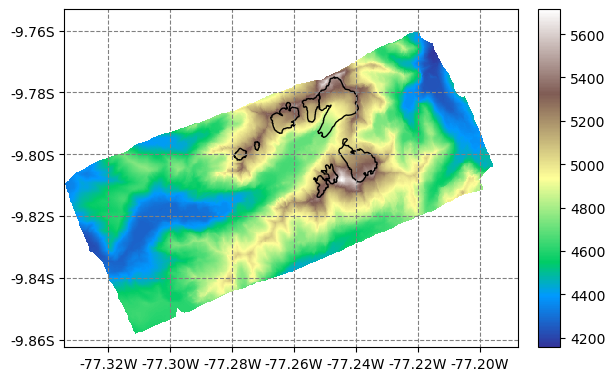

In [2]:
# Create gdir without calving
cfg.initialize(logging_level='ERROR') # supress print outputs
cfg.PATHS['working_dir'] = os.getcwd()
OUTPUTS = os.getcwd()+'/Outputs/'
initialization_files = '/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/MA_Thesis/Final_QQ_inputs/' #  '/home/tshutkin/OGGM/GPR_A_factor_calibration/initialization_files/'

inventory=gpd.read_file(initialization_files+'QQ_inventory_final_2008.shp')
intersects_path=initialization_files+'QQ_intersects_final_2008.shp'
intersects=gpd.read_file(intersects_path)

# Update RGI attributes    
inventory.loc[0,'Name'] = 'Queshque'
names=[]
for i,n in enumerate(inventory.Name.values):
    if type(n)!=str:
        n=f'Glacier_{i}'
    names.append(n)
inventory['Name']=names

inventory.loc[0,'TermType'] = 2 # for lake terminating glacier

cfg.set_intersects_db(intersects_path) # Set intersects file
cfg.PATHS['dem_file'] = initialization_files+'QQ_lidar_4326_10m.tif' # Use 2008 LiDAR DEM

data = xr.where(xr.open_rasterio(cfg.PATHS['dem_file'])>0,xr.open_rasterio(cfg.PATHS['dem_file']),np.nan)
grid = data.salem.grid
smap=salem.Map(grid=grid)
smap.set_data(data)
smap.set_plot_params(cmap='terrain')
smap.set_shapefile(inventory, facecolor='none',edgecolor='k')
smap.visualize();

In [3]:
## Static Parameters ##
cfg.PARAMS['border'] = 10 # For calibrating present day glaciers. CHANGE FOR MONTE CARLO
cfg.PARAMS['use_multiprocessing'] = True # Important for speed
cfg.PARAMS['use_multiple_flowlines'] = True # More realistic flowlines
cfg.PARAMS['hydro_month_sh']= 1 # Resolve hydro year ambiguity by using January as month 1..
cfg.PARAMS['use_rgi_area'] = False # calcuate areas from inventory
cfg.PARAMS['inversion_fs'] = 0 # Neglect sliding during inversion
cfg.PARAMS['fs'] = 0 # Neglect sliding in model runs
cfg.PARAMS['baseline_climate']='CRU'
# Set fixed gridcell resolution
# Important!
cfg.PARAMS['grid_dx_method']='fixed' 
cfg.PARAMS['fixed_dx']=10

2024-03-28 08:36:47: oggm.cfg: PARAMS['border'] changed from `40` to `10`.
2024-03-28 08:36:47: oggm.cfg: Multiprocessing switched ON after user settings.
2024-03-28 08:36:47: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.
2024-03-28 08:36:47: oggm.cfg: PARAMS['use_rgi_area'] changed from `True` to `False`.
2024-03-28 08:36:47: oggm.cfg: PARAMS['grid_dx_method'] changed from `square` to `fixed`.
2024-03-28 08:36:47: oggm.cfg: PARAMS['fixed_dx'] changed from `50.0` to `10`.


In [4]:
# Create gdirs
gdirs = workflow.init_glacier_directories(inventory[:1],reset=False, force=False)

# # Geometry tasks
# workflow.execute_entity_task(tasks.define_glacier_region, gdirs, source='USER');

# list_tasks = [tasks.glacier_masks,
#               tasks.compute_centerlines,
#               tasks.initialize_flowlines,
#               tasks.compute_downstream_line,
#               tasks.compute_downstream_bedshape,
#               tasks.catchment_area,
#               tasks.catchment_intersections,
#               tasks.catchment_width_geom,
#               tasks.catchment_width_correction]
    
# for task in list_tasks:
#     workflow.execute_entity_task(task, gdirs);

2024-03-28 08:36:47: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/oggm/utils/_funcs.py:546: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Multi' in geometry.type:
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/oggm/utils/_funcs.py:573: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type != 'Polygon':
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/oggm/utils/_workflow.py:2678: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for k, s in entity.iteritems():


/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/salem/graphics.py:745: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  geomtype = shape.iloc[0].geometry.type
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/salem/graphics.py:749: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Multi' in g.type:


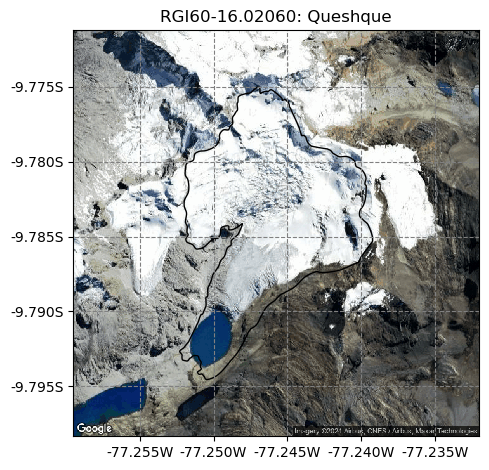

In [5]:
gdir=gdirs[0]
graphics.plot_googlemap(gdir)

/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/salem/graphics.py:656: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Multi' in geom.type:
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/salem/graphics.py:1175: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if g.type == 'Polygon':
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/salem/graphics.py:1178: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if g.type in ['LineString', 'LinearRing']:
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/salem/graphics.py:1182: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. Yo

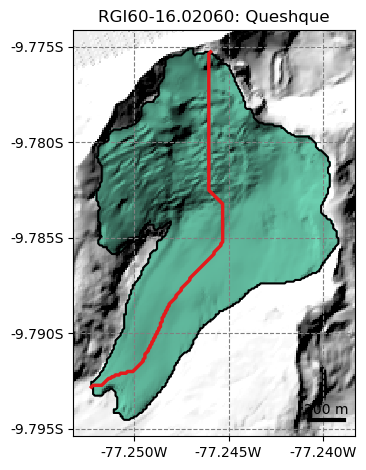

In [6]:
graphics.plot_catchment_areas(gdir)

In [7]:
## Save flowline for plotting
# utils.write_centerlines_to_shape([gdir],  # The glaciers to process
#                            path=OUTPUTS+'/Queshque_flowlines.shp',  # The output file
#                            to_tar=False,  # set to True to put everything into one single tar file
#                            to_crs=inventory.crs,  # Write into the projection of the original inventory
#                            keep_main_only=False,  # Write only the main flowline and discard the tributaries
#                            )

# flowlines = gpd.read_file(OUTPUTS+'/Queshque_flowlines.shp')
# fls_proj = salem.transform_geopandas(flowlines, to_crs=gdir.grid.proj) # reprojected to local grid

## 2] Climate Data

In [8]:
## Climate Tasks ##
# workflow.execute_entity_task(tasks.process_climate_data, [gdir])
# # Fetch the reference t* list and associated model parameters
# params_url = 'https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/oggm_v1.4/RGIV62/CRU/centerlines/qc3/pcp2.5'
# workflow.download_ref_tstars(base_url=params_url)

# # Now calibrate
# workflow.execute_entity_task(tasks.local_t_star, [gdir]);
# workflow.execute_entity_task(tasks.mu_star_calibration, [gdir]);

In [8]:
# Check MB Calibration Data
gdir.read_json('local_mustar')

{'rgi_id': 'RGI60-16.02060',
 't_star': 1962,
 'bias': 482.2009382859963,
 'mu_star_glacierwide': 77.9787721464355,
 'mu_star_per_flowline': [77.9787721464355],
 'mu_star_flowline_avg': 77.9787721464355,
 'mu_star_allsame': True}

## 3] Ice Thickness Calibration

In [3]:
initialization_files = '/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/MA_Thesis/Final_QQ_inputs/' #  '/home/tshutkin/OGGM/GPR_A_factor_calibration/initialization_files/'


In [4]:
# Examine 2014 GPR Data
gpr_path=initialization_files+'Queshque_GPR_2014.shp'
df = salem.read_shapefile(gpr_path)
coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
df.head()

,este,sur,altura_sup,altura_Bed,profundida,min_x,max_x,min_y,max_y,geometry,lon,lat
0,8917376.800,253651.7667,4936.9,4849.0121,87.8879,-77.245798,-77.245798,-9.786454,-9.786454,POINT (-77.24580 -9.78645),-77.245798,-9.786454
1,8917377.333,253651.7667,4937.0,4848.1355,88.8645,-77.245798,-77.245798,-9.786449,-9.786449,POINT (-77.24580 -9.78645),-77.245798,-9.786449
2,8917378.033,253651.7500,4937.0,4848.1355,88.8645,-77.245798,-77.245798,-9.786443,-9.786443,POINT (-77.24580 -9.78644),-77.245798,-9.786443
3,8917378.217,253651.7500,4937.0,4847.1590,89.8410,-77.245798,-77.245798,-9.786441,-9.786441,POINT (-77.24580 -9.78644),-77.245798,-9.786441
4,8917379.267,253651.7500,4937.1,4848.2355,88.8645,-77.245798,-77.245798,-9.786432,-9.786432,POINT (-77.24580 -9.78643),-77.245798,-9.786432


In [5]:
# Reproject data to local glacier grid projection
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

NameError: name 'gdir' is not defined

##### Split into calibration and validation datasets

In [8]:
all_coords = df.index.to_list()
Cal_coords, Val_coords = train_test_split(all_coords, test_size=0.5, random_state=42)
Cal = df.loc[Cal_coords]
Val = df.loc[Val_coords]   

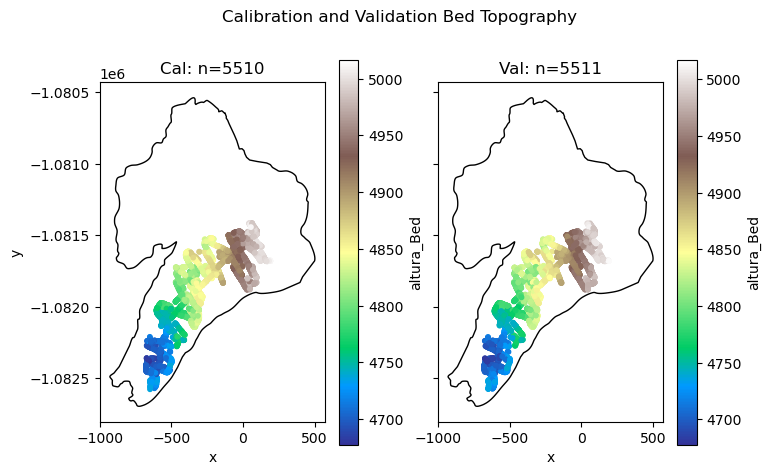

In [9]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,5),sharey=True)
f.suptitle('Calibration and Validation Bed Topography');
for ax,title,data in zip([ax1,ax2],['Cal','Val'],[Cal,Val]):
    gdir.read_shapefile('outlines').plot(ax=ax, facecolor='none', edgecolor='k');
    ax.set_title(f'{title}: n={len(data)}');
    
Cal.plot.scatter(x='x', y='y', c='altura_Bed', cmap='terrain', s=10, ax=ax1);
Val.plot.scatter(x='x', y='y', c='altura_Bed', cmap='terrain', s=10, ax=ax2);


##### Aggregate Calibration Data to Gridcell REsolution

/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/MA_Thesis/Final_python_scripts/GlacierCalibration.py:112: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_agg = df_agg.groupby('ij').mean()


Dataframe looks good!


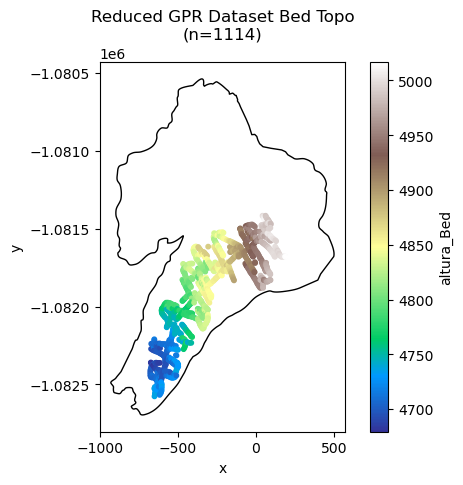

In [10]:
# Aggregate to Gridcell resolution
df_agg = aggregate_gpr_data_clip(gdir, Cal, plot=False) # Input Cal data for aggregation
geom =gdir.read_shapefile('outlines')
# and plot it
f, ax = plt.subplots()
df_agg.plot.scatter(x='x', y='y', c='altura_Bed', cmap='terrain', s=10, ax=ax);
geom.plot(ax=ax, facecolor='none', edgecolor='k');
ax.set_title(f'Reduced GPR Dataset Bed Topo\n(n={len(df_agg)})');

In [11]:
print(f'The GPR calibration dataset has been reduced from {len(Cal)} to {len(df_agg)} points, but the data retains the same distribution')

The GPR calibration dataset has been reduced from 5510 to 1114 points, but the data retains the same distribution


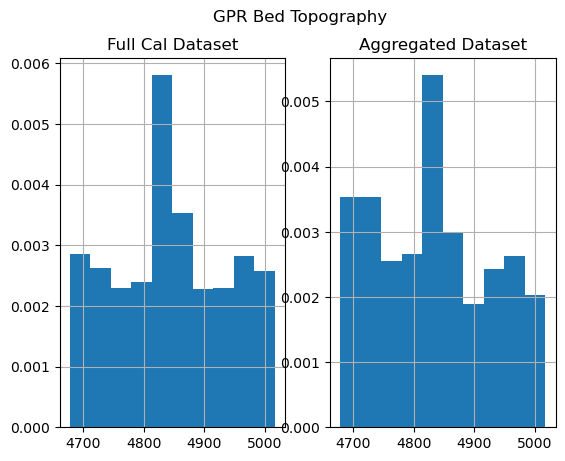

In [12]:
f,(ax1,ax2)=plt.subplots(1,2)
ax1.set_title('Full Cal Dataset')
ax2.set_title('Aggregated Dataset')
f.suptitle('GPR Bed Topography');

Cal.altura_Bed.hist(ax=ax1,density=True);
df_agg.altura_Bed.hist(ax=ax2,density=True);

### Calculate 2008 Ice thickness from Bed Topography

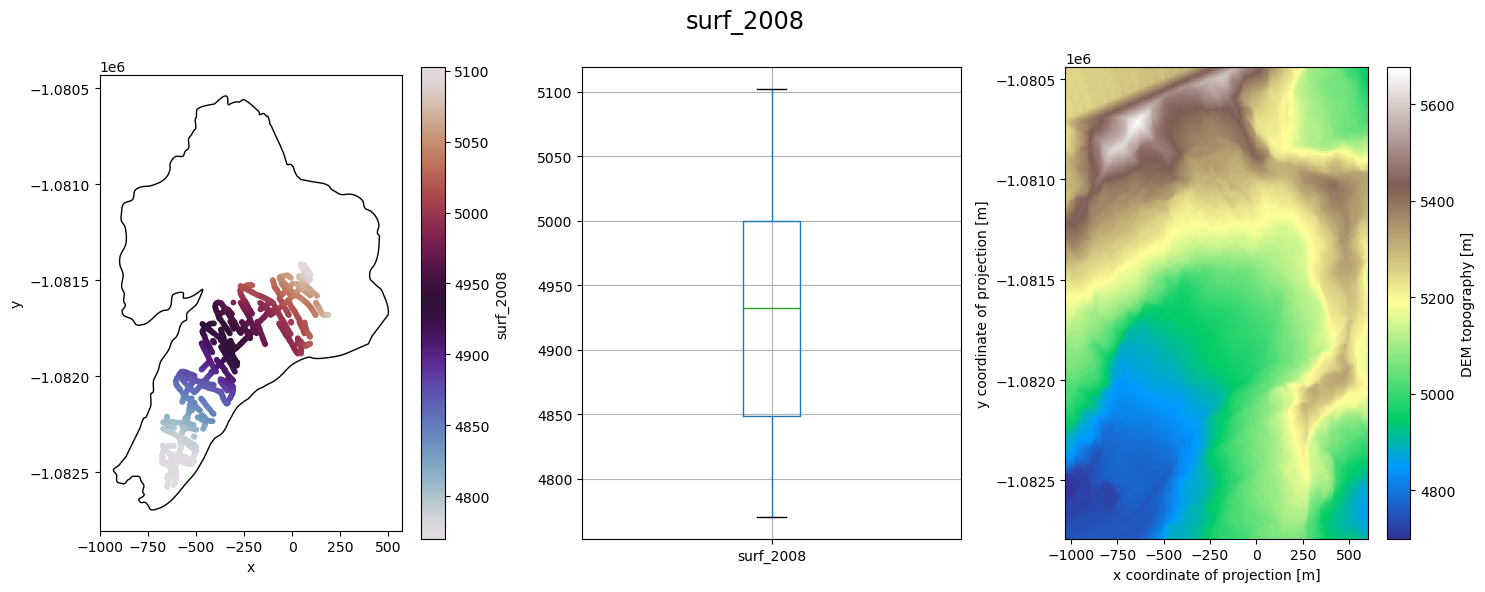

In [13]:
# 2008 Surface Elevation
surf = xr.open_dataset(gdir.get_filepath('gridded_data')).topo # Get surface topo from dem
df_agg['surf_2008'] = surf.interp(x=('z', df_agg.x), y=('z', df_agg.y))

# View gridded variables
f, (ax,ax1,ax2) = plt.subplots(1,3,figsize=(15,6))
var='surf_2008'
f.suptitle(var,fontsize='xx-large');
df_agg.plot.scatter(x='x', y='y', c=var, cmap='twilight', s=10, ax=ax);

geom =gdir.read_shapefile('outlines')
geom.plot(ax=ax, facecolor='none', edgecolor='k');
surf.plot(ax=ax2,cmap='terrain')
df_agg.boxplot(var,ax=ax1)
plt.tight_layout()

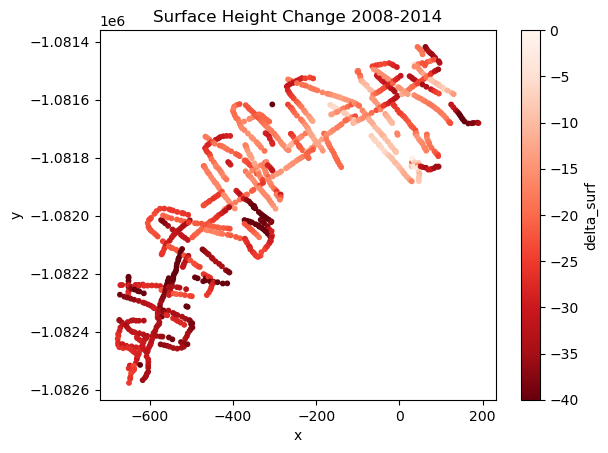

In [14]:
df_agg['delta_surf']= df_agg.altura_sup-df_agg.surf_2008

f,ax = plt.subplots()
ax.set_title('Surface Height Change 2008-2014');
var='delta_surf'
df_agg.plot.scatter(x='x', y='y', c=var, cmap='Reds_r',vmax=0,vmin=-40, s=10, ax=ax);

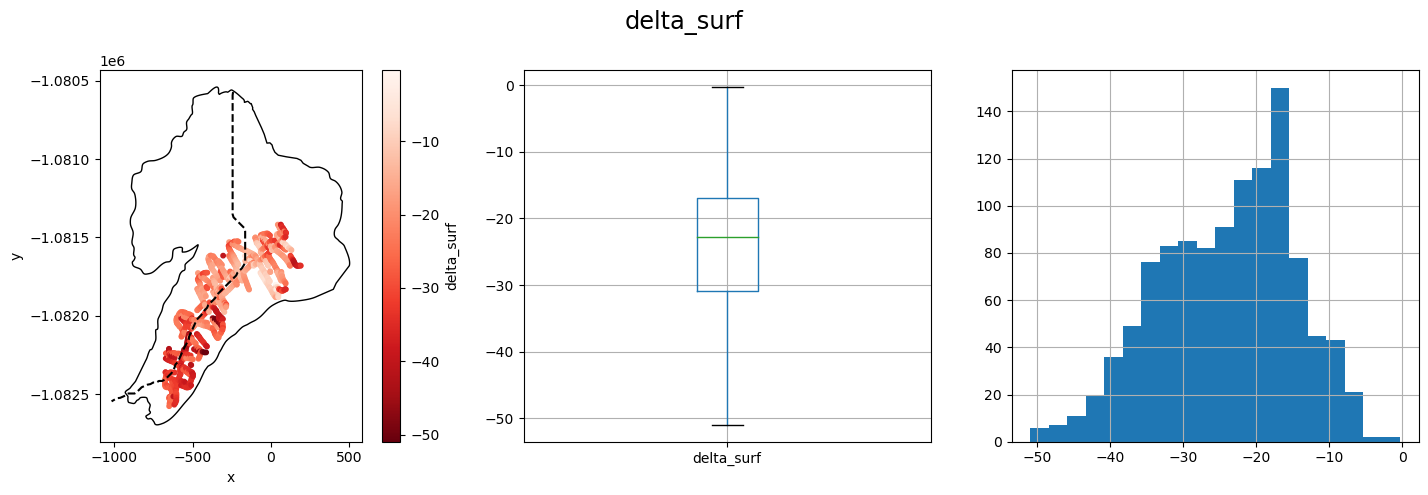

In [175]:
# View gridded variables
fls=gdir.read_pickle('model_flowlines')[0]
df_fls = pd.DataFrame()
df_fls['lon']=fls.point_lons
df_fls['lat']=fls.point_lats
# Reproject data to local glacier grid projection
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df_fls['lon'].values, df_fls['lat'].values)
df_fls['x'] = xx
df_fls['y'] = yy

f, (ax,ax1,ax2) = plt.subplots(1,3,figsize=(15,5))
var='delta_surf'
f.suptitle(var,fontsize='xx-large');
df_agg.plot.scatter(x='x', y='y', c=var, cmap='Reds_r', s=10, ax=ax);

geom =gdir.read_shapefile('outlines')
geom.plot(ax=ax, facecolor='none', edgecolor='k');
ax.plot(df_fls.x,df_fls.y,linestyle='--',color='k');
df_agg.boxplot(var,ax=ax1)
df_agg[var].hist(bins=20,ax=ax2);
plt.tight_layout()

In [100]:
# Bin Data by 2008 Surface Height
bins=np.arange(4760,5100,10)
bins=np.append(bins,np.inf)
names = [str(bins[i+1])[:-2] for i in range(len(bins)-1)]
names[-1]='5090+'
len(names)


34

In [92]:
df_agg['surf_2008_bin']=pd.cut(df_agg['surf_2008'], bins, labels=names)
df_agg.groupby(['surf_2008_bin']).count()

,lon,lat,profundida,altura_sup,altura_Bed,x,y,i,j,surf_2008,delta_surf
surf_2008_bin,,,,,,,,,,,
4770,2,2,2,2,2,2,2,2,2,2,2
4780,107,107,107,107,107,107,107,107,107,107,107
4790,31,31,31,31,31,31,31,31,31,31,31
4800,22,22,22,22,22,22,22,22,22,22,22
4810,36,36,36,36,36,36,36,36,36,36,36
4820,15,15,15,15,15,15,15,15,15,15,15
4830,11,11,11,11,11,11,11,11,11,11,11
4840,28,28,28,28,28,28,28,28,28,28,28
4850,30,30,30,30,30,30,30,30,30,30,30


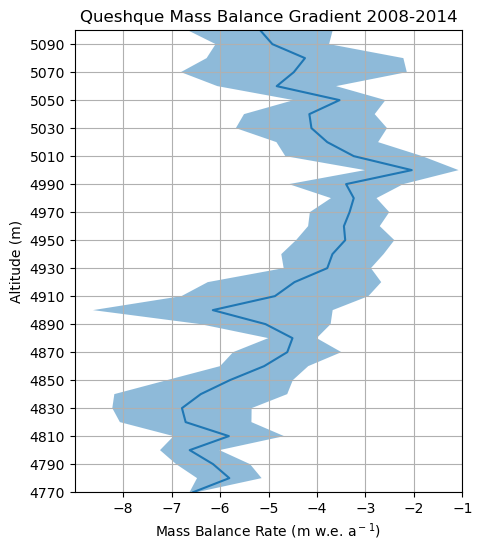

In [160]:
rho_ice = 0.90 # kg/m3
dt = 2014-2008

df_agg['mwe_per_year'] = df_agg.delta_surf.values / dt / rho_ice
dfmbg = df_agg.groupby(['surf_2008_bin']).mean()
mwe_sigma = df_agg.groupby(['surf_2008_bin']).std().mwe_per_year.values

dfmbg['low'] = dfmbg.mwe_per_year.values - mwe_sigma
dfmbg['high'] = dfmbg.mwe_per_year.values + mwe_sigma
#dfmbg['surf_2008_bin'] = dfmbg.index.values
f,ax=plt.subplots(figsize=(5,6))
ax.plot(dfmbg.mwe_per_year,dfmbg.index.values)
ax.fill_betweenx(y=dfmbg.index.values,x1=dfmbg.low,x2=dfmbg.high,alpha=0.5)

#plt.fill_between(x=dfmbg.index.values,y1=dfmbg.low,y2=dfmbg.high,alpha=0.5)
ax.set_xticks(np.arange(-8,0));
ax.set_yticks(np.arange(0,len(dfmbg),2))
ax.set_title('Queshque Mass Balance Gradient 2008-2014');
ax.set_ylabel('Altitude (m)')
ax.set_xlabel('Mass Balance Rate (m w.e. a$^-$$^1$)');
ax.set_ylim(['4770','5090+'])
ax.set_xlim([-9,-1])
ax.grid()

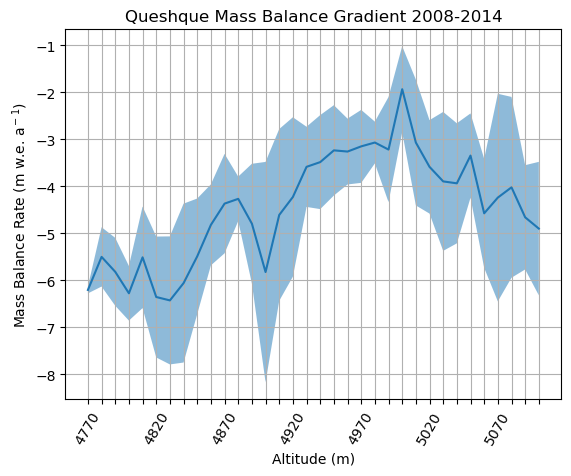

In [145]:
rho_ice = 0.95 # kg/m3
dt = 2014-2008

df_agg['mwe_per_year'] = df_agg.delta_surf.values / dt / rho_ice
dfmbg = df_agg.groupby(['surf_2008_bin']).mean()
mwe_sigma = df_agg.groupby(['surf_2008_bin']).std().mwe_per_year.values

dfmbg['low'] = dfmbg.mwe_per_year.values - mwe_sigma
dfmbg['high'] = dfmbg.mwe_per_year.values + mwe_sigma
#dfmbg['surf_2008_bin'] = dfmbg.index.values
dfmbg['mwe_per_year'].plot()

plt.fill_between(x=dfmbg.index.values,y1=dfmbg.low,y2=dfmbg.high,alpha=0.5)
plt.xticks(dfmbg.index.values,rotation=60);
plt.title('Queshque Mass Balance Gradient 2008-2014');
plt.xlabel('Altitude (m)')
plt.ylabel('Mass Balance Rate (m w.e. a$^-$$^1$)');
plt.grid()

In [108]:
shc = df_agg.groupby(['surf_2008_bin']).mean().delta_surf
rho_ice = 0.9 # kg/m3
dt = 2014-2008
mbg = shc/dt/rho_ice
dfmbg=pd.DataFrame()
dfmbg['mwe'] = mbg
mbg_sigma = df_agg.groupby(['surf_2008_bin']).std().mbg.values
#dfmbg = df_agg[['mb',"surf_2008_bin"]].groupby(['surf_2008_bin']).mean()
dfmbg['low'] = mbg-mbg_sigma
dfmbg['high'] = mbg+mbg_sigma
dfmbg['mwe'].plot()
plt.fill_between(x=dfmbg.index.values,y1=dfmbg.low,y2=dfmbg.high,alpha=0.5)
plt.xticks(dfmbg.index.values,rotation=60);
plt.title('Queshque Surface Height Change 2008-2014');
plt.xlabel('Altitude Range (m)')
plt.ylabel('Surface Height Change (m w.e. a$^-$$^1$)');
plt.grid()

AttributeError: 'DataFrame' object has no attribute 'mbg'

In [54]:
# Group by binned surface height




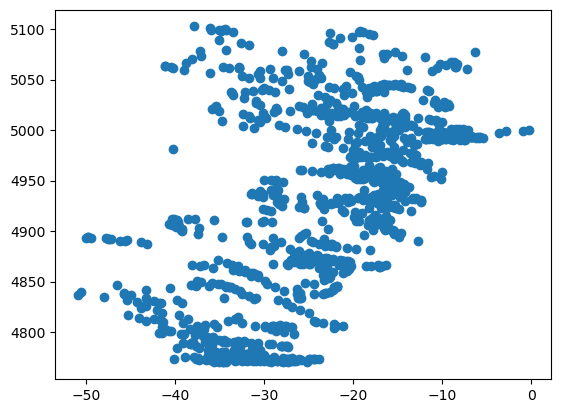

In [18]:
# Calculate MB Gradient from surface hgt change?
#plt.scatter(df_agg['delta_surf'],df_agg['surf_2008']);
bins = [0, 2, 18, 35, 65, np.inf]
names = ['<2', '2-18', '18-35', '35-65', '65+']

df['AgeRange'] = pd.cut(df['Age'], bins, labels=names)

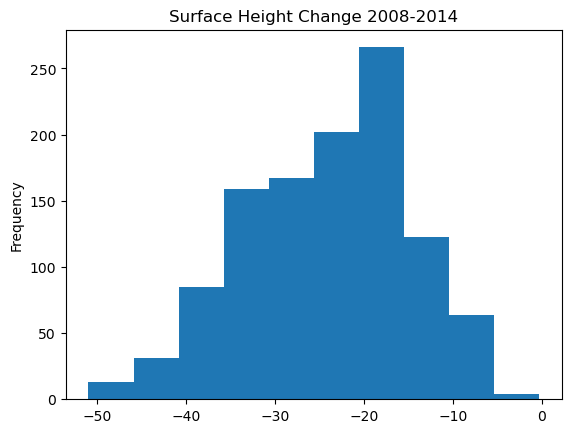

In [205]:
df_agg.delta_surf.plot.hist();
plt.title('Surface Height Change 2008-2014');

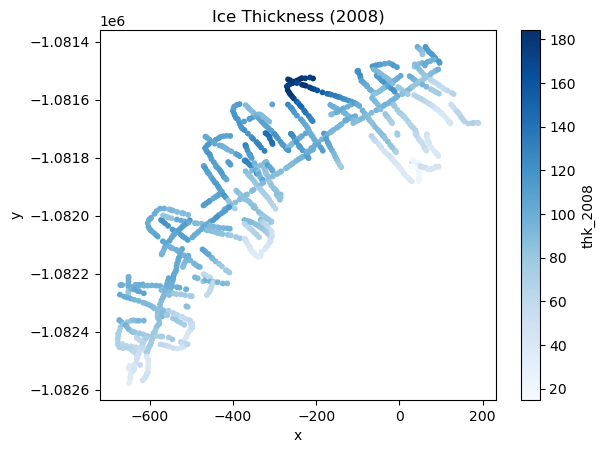

In [206]:
df_agg['thk_2008']= df_agg.surf_2008-df_agg.altura_Bed

f,ax = plt.subplots()
ax.set_title('Ice Thickness (2008)');
var='thk_2008'
df_agg.plot.scatter(x='x', y='y', c=var, cmap='Blues', s=10, ax=ax);

### Compare to 2009 GPR
Two Datasets:
    1] thk_2008 -- Thickness as the difference between the 2008 lidar and the bed topography from the 2014 survey;
    2] profundida -- Direct ice thickness radar measurements from the 2009 GPR
    
Here I use n-nearest neighbors interpolation to estimate the thk_2008 values at each profundida point. While some significant discrepancies exist, no system bias is apparent, not even evidence of systemic thinning between 2008 and 2009.

In [207]:
gpr_path=initialization_files+'Queshque_GPR_2009.shp' # Access GPR
df_09=salem.read_shapefile(gpr_path)

# Reproject data to local glacier grid projection
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df_09['lon'].values, df_09['lat'].values)
df_09['x'] = xx
df_09['y'] = yy

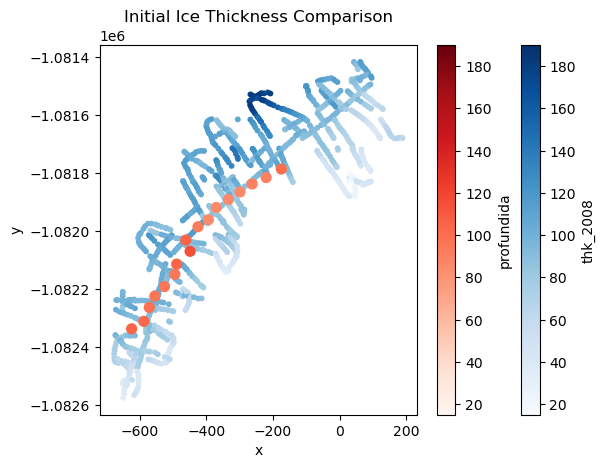

In [208]:
f,ax = plt.subplots()
ax.set_title('Initial Ice Thickness Comparison');
var='thk_2008'
df_agg.plot.scatter(x='x', y='y', c=var, cmap='Blues', s=10, vmin=15,vmax=190, ax=ax);
df_09.plot.scatter(x='x', y='y', c='profundida', cmap='Reds', s=50, vmin=15,vmax=190, ax=ax);

In [10]:
# Calculate Distance Matrix Between Two Datasets
def distance(a,b):
    from math import sqrt
    d=(a.x-b.x)**2 + (a.y-b.y)**2
    return sqrt(d)

def D_Matrix(A,B):
    D=np.zeros((len(A),len(B)))
    for i in range(len(A)):
        for j in range(len(B)):
            a=A.iloc[i]
            b=B.iloc[j]
            D[i,j]=distance(a,b)
    return D

In [6]:
# Calculate distance matrix
dist = D_Matrix(df_09,df_agg)

NameError: name 'D_Matrix' is not defined

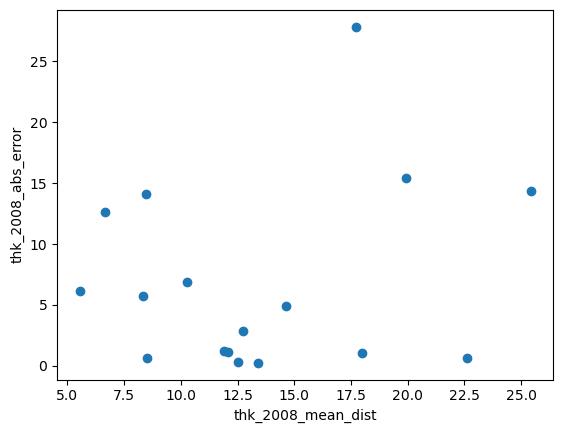

In [211]:
# Find thickness values from the extensive survey that correspond to each point from the 2009 survey 
# using the most proximal points

n=4 # number of nearest neighbors
vals_ag=[]
distances=[]
for i in range(len(df_09)):
    keys=dist[i].argsort()[:n] # find indeces of n smallest elements
    distances.append(np.mean(dist[i][keys])) # Record mean distance of 2009 survey point to n closest 2014 survey points
    vals_ag.append(np.mean(df_agg.iloc[keys].thk_2008)) # take average thickness value 
    
df_09['thk_2008']=vals_ag
df_09['thk_2008_mean_dist'] = distances
df_09['thk_2008_error'] = df_09.thk_2008 - df_09.profundida
df_09['thk_2008_abs_error'] = abs(df_09.thk_2008 - df_09.profundida)
plt.scatter(df_09.thk_2008_mean_dist,df_09.thk_2008_abs_error);
plt.xlabel('thk_2008_mean_dist')
plt.ylabel('thk_2008_abs_error');

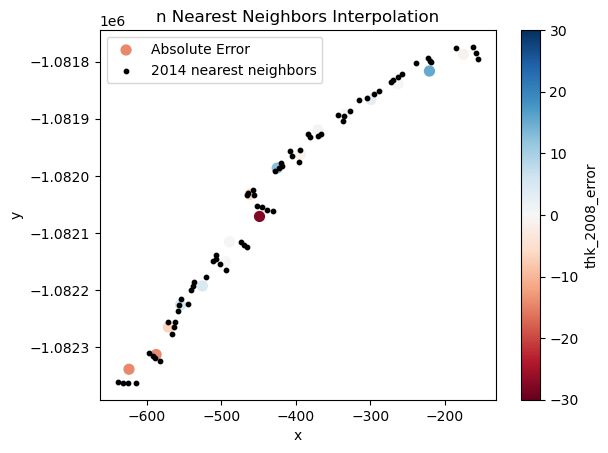

In [212]:
# Make sure this works
n=4
f,ax = plt.subplots()
ax.set_title('n Nearest Neighbors Interpolation');

# Centerlines
#fls_proj.plot(ax=ax,color='pink',label='Glacier Flowline');

# GPR points
var='thk_2008_error'
df_09.plot.scatter(x='x', y='y', c=var, cmap='RdBu', s=50,vmin=-30,vmax=30, ax=ax,label='Absolute Error');
for point in range(len(df_09)):
    keys=dist[point].argsort()[:n]
    if point==0:
        df_agg.iloc[keys].plot.scatter(x='x', y='y', c='k', s=10, ax=ax, label='2014 nearest neighbors');
    else:
        df_agg.iloc[keys].plot.scatter(x='x', y='y', c='k', s=10, ax=ax)
ax.legend();

No systematic bias appears to exist between the two surveys

In [213]:
df_09.profundida.values,df_09.thk_2008.values

(array([105., 103.,  85.,  85.,  85.,  85.,  90.,  90., 100.,  99.,  96.,
         95.,  95., 105., 115., 105.,  93.]),
 array([ 90.64619985,  88.87397666,  83.81402891,  86.1435386 ,
         84.34687887,  87.87129724,  89.71749908, 105.41758677,
         98.97689416,  92.10707154, 101.69386783,  99.87902482,
         95.24804079, 105.60194289,  87.16906034,  98.8884775 ,
        105.60344206]))

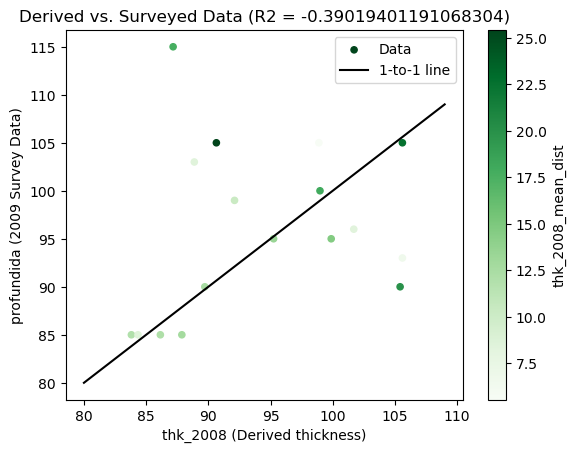

In [214]:
f,ax=plt.subplots()
df_09.plot.scatter(x='thk_2008',y='profundida',c='thk_2008_mean_dist',cmap='Greens',label='Data',ax=ax)
ax.plot(np.arange(80,110),np.arange(80,110),color='k',label='1-to-1 line')
ax.legend();
ax.set_xlabel('thk_2008 (Derived thickness)');
ax.set_ylabel('profundida (2009 Survey Data)');
ax.set_title(f'Derived vs. Surveyed Data (R2 = {r2_score(df_09.profundida.values,df_09.thk_2008.values)})');

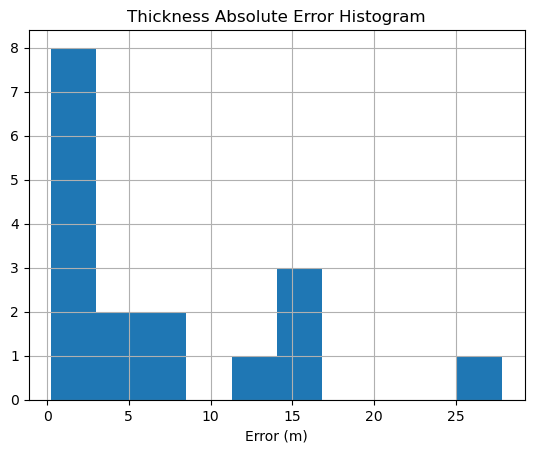

In [215]:
df_09.thk_2008_abs_error.hist()
plt.title('Thickness Absolute Error Histogram');
plt.xlabel('Error (m)');

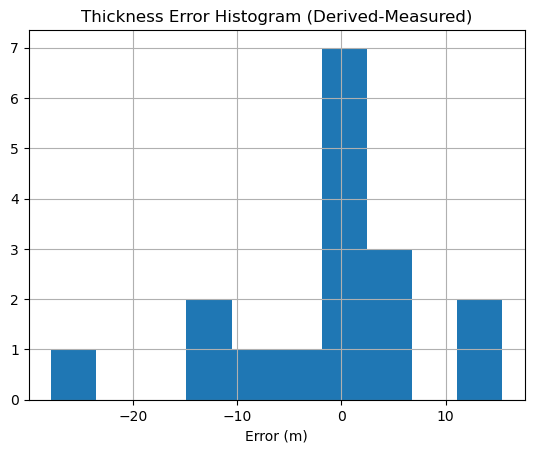

In [216]:
df_09.thk_2008_error.hist()
plt.title('Thickness Error Histogram (Derived-Measured)');
plt.xlabel('Error (m)');

In [217]:
# Ice thickness means are about equal despite local error
df_09[['profundida','thk_2008']].mean()

profundida    95.941176
thk_2008      94.235225
dtype: float64

### Run Ice Thickness Calibration with Cal Dataset

In [182]:

def custom_distribute_thickness_per_altitude(gdir, add_slope=True,
                                      smooth_radius=None,
                                      dis_from_border_exp=0.25,
                                            varname_suffix=''):
    """Compute a thickness map by redistributing mass along altitudinal bands.

    This is a rather cosmetic task, not relevant for OGGM but for ITMIX.
    Unlike OGGM function, does not write file.

    Parameters
    ----------
    gdir : :py:class:`oggm.GlacierDirectory`
        the glacier directory to process
    add_slope : bool
        whether a corrective slope factor should be used or not
    smooth_radius : int
        pixel size of the gaussian smoothing. Default is to use
        cfg.PARAMS['smooth_window'] (i.e. a size in meters). Set to zero to
        suppress smoothing.
    dis_from_border_exp : float
        the exponent of the distance from border mask
    """
    from oggm.core.gis import gaussian_blur
    
    # Variables
    grids_file = gdir.get_filepath('gridded_data')
    # See if we have the masks, else compute them
    with utils.ncDataset(grids_file) as nc:
        has_masks = 'glacier_ext_erosion' in nc.variables
    if not has_masks:
        from oggm.core.gis import gridded_attributes
        gridded_attributes(gdir)

    with utils.ncDataset(grids_file) as nc:
        topo_smoothed = nc.variables['topo_smoothed'][:]
        glacier_mask = nc.variables['glacier_mask'][:]
        dis_from_border = nc.variables['dis_from_border'][:]
        if add_slope:
            slope_factor = nc.variables['slope_factor'][:]
        else:
            slope_factor = 1.

    # Along the lines
    cls = gdir.read_pickle('inversion_output')
    fls = gdir.read_pickle('inversion_flowlines')
    hs, ts, vs, xs, ys = [], [], [], [], []
    for cl, fl in zip(cls, fls):
        hs = np.append(hs, fl.surface_h)
        ts = np.append(ts, cl['thick'])
        vs = np.append(vs, cl['volume'])
        try:
            x, y = fl.line.xy
        except AttributeError:
            # Squeezed flowlines, dummy coords
            x = fl.surface_h * 0 - 1
            y = fl.surface_h * 0 - 1
        xs = np.append(xs, x)
        ys = np.append(ys, y)

    init_vol = np.sum(vs)

    # Assign a first order thickness to the points
    # very inefficient inverse distance stuff
    thick = glacier_mask * np.NaN
    for y in range(thick.shape[0]):
        for x in range(thick.shape[1]):
            phgt = topo_smoothed[y, x]
            # take the ones in a 100m range
            starth = 100.
            while True:
                starth += 10
                pok = np.nonzero(np.abs(phgt - hs) <= starth)[0]
                if len(pok) != 0:
                    break
            sqr = np.sqrt((xs[pok]-x)**2 + (ys[pok]-y)**2)
            pzero = np.where(sqr == 0)
            if len(pzero[0]) == 0:
                thick[y, x] = np.average(ts[pok], weights=1 / sqr)
            elif len(pzero[0]) == 1:
                thick[y, x] = ts[pzero]
            else:
                raise RuntimeError('We should not be there')

    # Distance from border (normalized)
    dis_from_border = dis_from_border**dis_from_border_exp
    dis_from_border /= np.mean(dis_from_border[glacier_mask == 1])
    thick *= dis_from_border

    # Slope
    thick *= slope_factor

    # Smooth
    dx = gdir.grid.dx
    if smooth_radius != 0:
        if smooth_radius is None:
            smooth_radius = np.rint(cfg.PARAMS['smooth_window'] / dx)
        thick = gaussian_blur(thick, int(smooth_radius))
        thick = np.where(glacier_mask, thick, 0.)

    # Re-mask
    utils.clip_min(thick, 0, out=thick)
    thick[glacier_mask == 0] = np.NaN
    assert np.all(np.isfinite(thick[glacier_mask == 1]))

    # Conserve volume
    tmp_vol = np.nansum(thick * dx**2)
    thick *= init_vol / tmp_vol
    
    return thick

def map_dist_thk(gdir, ds=None, glen_a=None, fs=None, varname_suffix=''):
    
    # OGGM stuff
    workflow.inversion_tasks([gdir], glen_a=glen_a, fs=fs, filter_inversion_output=True)
    volume= tasks.get_inversion_volume(gdir)
    thick = custom_distribute_thickness_per_altitude(gdir,varname_suffix=varname_suffix) # calculate dist thicknesss without writing to file
    
    return_ds=False
    if ds is None:
        return_ds=True # remember to spit out for later use
        # Get dimensions from glacier directory
        with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
            x_vals= ds.x.values
            y_vals= ds.y.values
    else:
        x_vals=ds.x.values
        y_vals=ds.y.values
    
    da = xr.DataArray(
            data=thick, # need to transpose array for some reason, I think due to the order that I looped through the dataset
            dims=["y", "x"],
            coords=dict(
                y=y_vals,
                x=x_vals,

            ),
            attrs=dict(
                name=varname_suffix,
                Creep = glen_a,
                Volume = volume,
                description=f"Distributed thickness predicted by OGGM (Model run suffix: {varname_suffix}.",
                units="meters",
            ),
        )
    
    ds.update({f'param_{varname_suffix}_dist_thk':da}) # store thickness map

    if return_ds:
        return da, volume, ds
    else:
        return da, volume



def write_dist_thk(data):
    
    
    return



def error_eval(model, data, data_var, return_df=False):
    """
    Evaluate gridded model output data (xarray dataarray) of variable
    against point observations (geopandas dataframe) of variable (data_var)
    Returns RMSE, MAE, with option of point by point error table output.
    """
    from math import sqrt 
    
    df=data.copy()
    df['i']=df.i.values.astype(int) # ensure integer indeces
    df['j']=df.j.values.astype(int)
    df['model_thk'] = model.isel(x=('z', df['i']), y=('z', df['j'])) # take raster points with GPR data
    df=df.dropna() # Fixes bug with Arteson and others....Not suree of consequenses yet...
    ERROR = df['model_thk']-df[data_var] # Find deviation from observation
    AE = abs(ERROR)
    ME = ERROR.mean()
    MAE = AE.mean()
    RMSE = sqrt((ERROR**2).mean())
    
    df['error']=ERROR
    df['abs_error']=AE
    
   # assert (isnan(error)==True), 'There is a problem in obs/model allignment. Check for null values'
    if return_df==True:
        return RMSE, MAE, ME, df
    else:
        return RMSE, MAE, ME
    
    
# Work in progress
def calibrate_param(gdir, obs, model_var, data_var, start_val=2.4e-24, metric='RMSE', precision=0.1):
    """
    Optimal calibration of glen's A value (creep parameter) given an OGGM glacier directory and observation data
    Optimize against metric "RMSE", "MAE"
    """
    
    if metric=='RMSE':
        metric=0
    elif metric=='MAE':
        metric=1
    else:
        raise ValueError('metric must be one of RMSE or MAE')
        
    # First Guess
    da0,volume0,ds = map_dist_thk(gdir, glen_a=start_val,varname_suffix='')
    rmse0 = error_eval(da0, obs, model_var, data_var)[metric]
    # Second Guess
    da1,volume1 = map_dist_thk(gdir, ds=ds, glen_a=start_val*2,varname_suffix='')
    rmse1 = error_eval(da1, obs, model_var, data_var)[metric]
    
    # Now iterate
    if abs(volume0-volume1)/volume0 < precision:
        print(f'Calibration completed. The Optimized Creep parameters are  {da0.Creep} and {da1.Creep} at a precision of {precision*100}%')
        return da0.Creep, da1.Creep

    return
    

In [183]:
# Function to randomly divide calibration data and minimize glacier thickness MAE against GPR data
# Outputs: Candidate Creep Param, "A-factor", RMSE, MAE, ME, glacier volume for the given TRAIN/TEST split
# This function is to be run iteratively producing a candidate param PDF

def Creep_Cal(glacier, param_values, obs, model, model_varname,varname_suffix=''):
    default_glen_a = 2.4e-24
    all_coords = obs.index.to_list()
    TRAIN_coords, TEST_coords = train_test_split(all_coords,test_size=0.5)
    TRAIN = obs.loc[TRAIN_coords]
    TEST = obs.loc[TEST_coords]
    
    training_MAE = []

    for A in param_values:
        try:
            da,v = map_dist_thk(gdir, ds=model, glen_a=A, fs=None, varname_suffix='')
            MAE = error_eval(da, TRAIN, model_varname)[1]
            if np.isnan(MAE)==True:
                break
            training_MAE.append(MAE)
        except ValueError:
            pass
    candidate = param_values[training_MAE.index(min(training_MAE))] # Take parameter value for lowest error across training dataset
    da,volume = map_dist_thk(gdir, ds=model, glen_a=candidate, fs=None, varname_suffix=varname_suffix)
    model.update({f'cand_{varname_suffix}_dist_thk':da}) # store thickness map
    RMSE,MAE,ME = error_eval(da, TEST, model_varname) # evaluate error against testing dataset        
    
    return candidate,candidate/default_glen_a,RMSE,MAE,ME,volume

#### Evaluate parameter space for calibration (sensitivty test)
A-factor between 1.5 - 2.25 minimizes error (MAE) and bias (ME)

In [220]:
cfg.PARAMS['use_kcalving_for_inversion'] =False
default_glen_a=2.4e-24
var = 'thk_2008' # calibrate against derived thickness measurements
fs=0
# a_fac=np.arange(1.,3.1,0.25)
# glen_as = [2.4e-24*f for f in a_fac] # List of A_values to be used
# #reshuffle = 100 # Number of times to shuffle calibration data (e.i., number of candidate parameters to build PDF)

# sensitivity_MAE = []
# sensitivity_ME = []
# with xr.open_dataset(gdir.get_filepath('gridded_data')) as model: # Get dimensions from glacier directory
#     for A in glen_as:
#         try:
#             da,v = map_dist_thk(gdir, ds=model, glen_a=A, fs=None, varname_suffix='')
#             RMSE,MAE,ME = error_eval(da, df_agg, var) # error against full calibration dataset
#             if np.isnan(MAE)==True:
#                 break
#             sensitivity_MAE.append(MAE)
#             sensitivity_ME.append(ME)
#         except ValueError:
#             pass
        


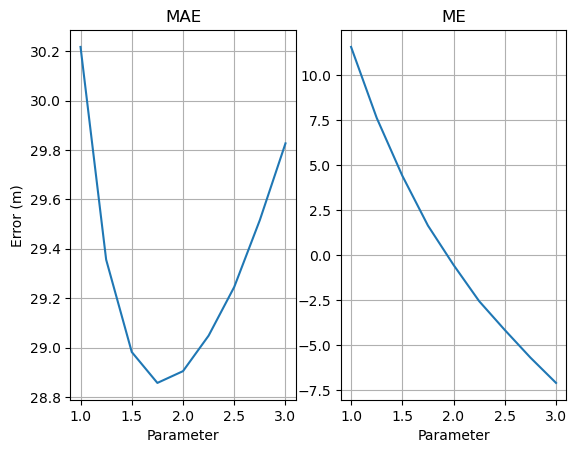

In [61]:
f,(ax1,ax2)=plt.subplots(1,2)
ax1.plot(a_fac,sensitivity_MAE);
ax1.set_title('MAE');
ax1.set_xlabel('Parameter');
ax1.set_ylabel('Error (m)');
ax1.grid()
ax2.plot(a_fac,sensitivity_ME);
ax2.set_title('ME');
ax2.set_xlabel('Parameter');
#ax2.set_ylabel('Error (m)');
ax2.grid()

In [221]:
# Set up parameters for model calibration
cfg.PARAMS['use_kcalving_for_inversion'] =False
default_glen_a=2.4e-24
var = 'thk_2008' # calibrate against derived thickness measurements
fs=0
a_fac=np.arange(1.5,2.26,0.02) # Range derived from sensitivity test
glen_as = [2.4e-24*f for f in a_fac] # List of A_values to be used
reshuffle = 100 # Number of times to shuffle calibration data (e.i., number of candidate parameters to build PDF)

# estimate time
total_runs = (len(glen_as)*reshuffle) + reshuffle
print(f'Estimated Runtime Under Given Parameters: ~{round((total_runs*0.8)/60)} minutes')

Estimated Runtime Under Given Parameters: ~52 minutes


In [35]:
# Run Calibration
# df_cand = pd.DataFrame(columns = ['A','A_fac','RMSE','MAE','ME','volume']) # to store outputs
# start_time = time.time()
# with xr.open_dataset(gdir.get_filepath('gridded_data')) as model:
#     for i in range(reshuffle):
#         cand = Creep_Cal(gdir, glen_as, df_agg, model, 'thk_2008',varname_suffix=str(i))
#         df_cand.loc[i]=np.array(cand)
#         print(f'--- Candidate {i} found after ~{(time.time()-start_time)//60} minutes ---')
        


In [36]:
#df_cand.A_fac.hist(bins=20);

## Open already created creep param candidate table

In [179]:
#df_cand.to_csv(OUTPUTS+'candidate_params.csv')
df_cand=pd.read_csv(OUTPUTS+'candidate_params.csv',index_col=0)
df_cand.head()

,A,A_fac,RMSE,MAE,ME,volume
0,4.224000e-24,1.76,43.937294,29.184498,3.097583,8.310792e+07
1,3.984000e-24,1.66,44.382674,28.802646,3.980843,8.405798e+07
2,4.368000e-24,1.82,42.433415,27.853875,0.250393,8.256818e+07
3,4.128000e-24,1.72,44.371107,28.881740,2.801936,8.348005e+07
4,4.560000e-24,1.90,42.318267,28.777072,-1.682064,8.188055e+07


In [223]:
df_cand.A_fac.mean(),df_cand.A_fac.mean()+df_cand.A_fac.std(),df_cand.A_fac.mean()-df_cand.A_fac.std()

(1.7982000000000002, 1.9084465556391812, 1.6879534443608193)

In [225]:
df_cand.A.mean(),df_cand.A.mean()+df_cand.A.std(),df_cand.A.mean()-df_cand.A.std()

(4.3156799999999994e-24, 4.580271733534034e-24, 4.051088266465965e-24)

In [184]:
# Initial Volume Uncertainty #
cfg.PARAMS['use_kcalving_for_inversion'] =False
da,v_mean,ds = map_dist_thk(gdir, glen_a=df_cand.A.mean(), fs=None, varname_suffix='Opt_A')
da1,v_1 = map_dist_thk(gdir,ds=ds, glen_a=df_cand.A.mean()+df_cand.A.std(), fs=None, varname_suffix='max_A')
da2,v_2 = map_dist_thk(gdir,ds=ds, glen_a=df_cand.A.mean()-df_cand.A.std(), fs=None, varname_suffix='min_A')

2024-03-28 12:00:58: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-03-28 12:00:58: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-03-28 12:00:59: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-03-28 12:00:59: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-03-28 12:00:59: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-03-28 12:00:59: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-03-28 12:01:00: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-03-28 12:01:00: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-03-28 12:01:00: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-03-28 12:01:00: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-03-28 12:01:00: oggm.workflow: Execute entity tasks [

In [185]:
# Volumes
v_mean,v_1,v_2

(82761803.20716305, 81809961.82031898, 83785692.99479456)

Expected values:
(82761803.20716305, 81809961.82031898, 83785692.99479456)

In [230]:
ds

<xarray.Dataset>
Dimensions:           (time: 145)
Coordinates:
  * time              (time) float64 2.008e+03 2.008e+03 ... 2.02e+03 2.02e+03
    hydro_year        (time) int64 ...
    hydro_month       (time) int64 ...
    calendar_year     (time) int64 ...
    calendar_month    (time) int64 ...
Data variables:
    volume_m3         (time) float64 ...
    volume_bsl_m3     (time) float64 ...
    volume_bwl_m3     (time) float64 ...
    area_m2           (time) float64 ...
    length_m          (time) float64 ...
    calving_m3        (time) float64 ...
    calving_rate_myr  (time) float64 ...
Attributes:
    description:          OGGM model output
    oggm_version:         1.5.3
    calendar:             365-day no leap
    creation_date:        2024-03-21 15:12:13
    water_level:          4727
    glen_a:               4.3156799999999994e-24
    fs:                   0
    mb_model_class:       MultipleFlowlineMassBalance
    mb_model_hemisphere:  sh

### Now Validate Against Validation Data
#### 1] Val dataset from derived ice thickness
#### 2] Observed (2009) data - Hypothesis:  Should be slightly thinner (positive model bias)?

/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/MA_Thesis/Final_python_scripts/GlacierCalibration.py:112: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_agg = df_agg.groupby('ij').mean()


Dataframe looks good!


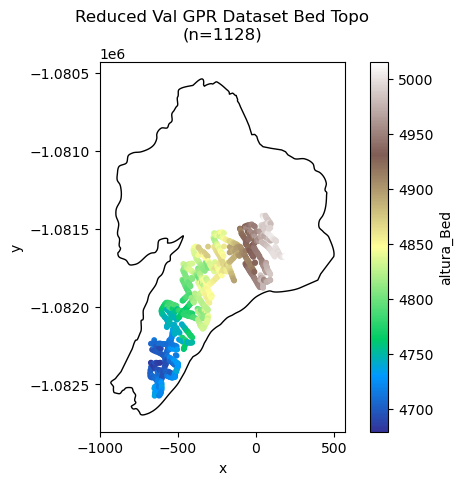

In [226]:
# Aggregate validation data to Gridcell resolution
df_Val = aggregate_gpr_data_clip(gdir, Val, plot=False) # Input Val data for aggregation
# and plot it
f, ax = plt.subplots()
df_Val.plot.scatter(x='x', y='y', c='altura_Bed', cmap='terrain', s=10, ax=ax);
geom =gdir.read_shapefile('outlines')
geom.plot(ax=ax, facecolor='none', edgecolor='k');
ax.set_title(f'Reduced Val GPR Dataset Bed Topo\n(n={len(df_Val)})');

In [227]:
print(f'The GPR calibration dataset has been reduced from {len(Val)} to {len(df_Val)} points, but the data retains the same distribution')

The GPR calibration dataset has been reduced from 5511 to 1128 points, but the data retains the same distribution


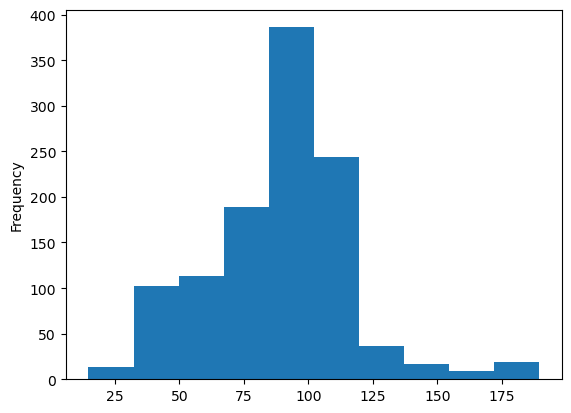

In [235]:
# 2008 Surface Elevation
surf = ds.topo # Get surface topo from dem
df_Val['surf_2008'] = surf.interp(x=('z', df_Val.x), y=('z', df_Val.y))
df_Val['delta_surf']= df_Val.altura_sup-df_Val.surf_2008
df_Val['thk_2008']= df_Val.surf_2008-df_Val.altura_Bed

df_Val.thk_2008.plot.hist();



In [236]:
# Calculate Error Metrics of Calibrated Results
error_Val=error_eval(ds.param_Opt_A_dist_thk, df_Val, 'thk_2008', return_df=True)
print(f'RMSE, MAE, and ME values against validation data: {error_Val[:3]}')

RMSE, MAE, and ME values against validation data: (44.18358843668079, 29.258015921267464, 1.6480233044598667)


###### Expected vals
RMSE, MAE, and ME values against validation data: (43.4645049376052, 28.92806041182457, 1.4936769382610682)

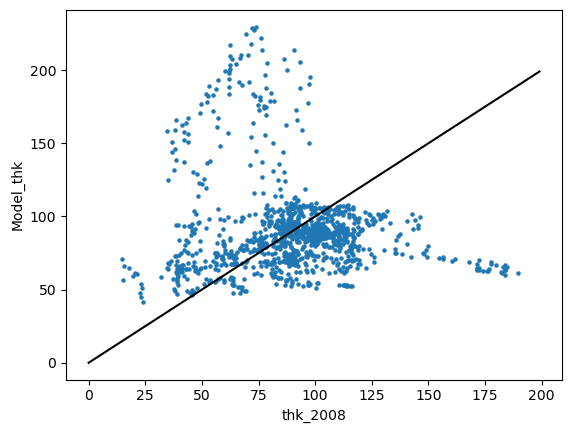

In [250]:
#error_Val[-1].head()#plot.hist(bins=30);
plt.scatter(error_Val[-1].thk_2008,error_Val[-1].model_thk, s=5)
plt.plot(np.arange(0,200),np.arange(0,200), color='k')
plt.xlabel('thk_2008');
plt.ylabel('Model_thk');

In [239]:
error_Val[-1]

,lon,lat,profundida,altura_sup,altura_Bed,x,y,i,j,surf_2008,delta_surf,thk_2008,model_thk,error,abs_error
ij,,,,,,,,,,,,,,,
0035_0179,-77.249942,-9.790399,71.286900,4776.750000,4705.463100,-672.814125,-1.082238e+06,35,179,4805.868396,-29.118396,100.405296,88.148922,-12.256374,12.256374
0035_0191,-77.249941,-9.791499,61.521500,4744.600000,4683.078500,-672.608419,-1.082360e+06,35,191,4780.078910,-35.478910,97.000410,177.613386,80.612976,80.612976
0035_0192,-77.249932,-9.791525,61.847033,4744.433333,4682.586300,-671.683770,-1.082363e+06,35,192,4779.704358,-35.271025,97.118058,190.532232,93.414173,93.414173
0035_0194,-77.249924,-9.791738,46.385300,4746.900000,4700.514700,-670.843841,-1.082386e+06,35,194,4776.889086,-29.989086,76.374386,213.539990,137.165604,137.165604
0035_0195,-77.249931,-9.791778,45.897000,4746.400000,4700.503000,-671.531540,-1.082391e+06,35,195,4776.406912,-30.006912,75.903912,221.966135,146.062224,146.062224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0119_0124,-77.242319,-9.785363,27.953225,5025.887500,4997.934275,163.185999,-1.081682e+06,119,124,5065.475479,-39.587979,67.541204,50.048179,-17.493025,17.493025
0120_0123,-77.242192,-9.785346,31.249000,5034.500000,5003.251000,177.129302,-1.081680e+06,120,123,5072.478708,-37.978708,69.227708,48.827000,-20.400708,20.400708
0120_0124,-77.242217,-9.785356,31.249000,5032.550000,5001.301000,174.343092,-1.081681e+06,120,124,5070.782558,-38.232558,69.481558,48.835737,-20.645821,20.645821


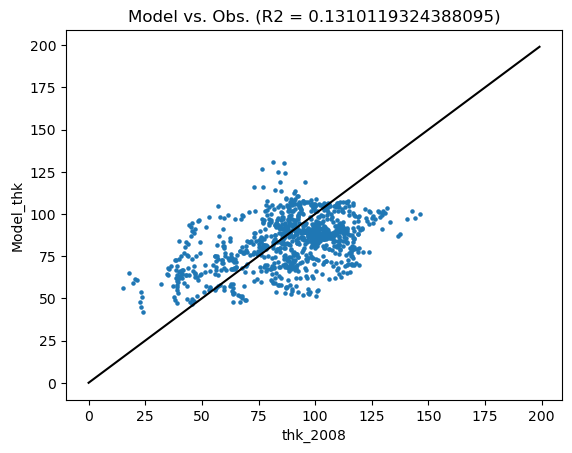

In [248]:
data = error_Val[-1].where(error_Val[-1].abs_error<=50).dropna()
plt.scatter(data.thk_2008,data.model_thk,s=5)
plt.plot(np.arange(0,200),np.arange(0,200), color='k')
plt.xlabel('thk_2008');
plt.ylabel('Model_thk');
plt.title(f'Model vs. Obs. (R2 = {r2_score(data.thk_2008.values,data.model_thk.values)})');

In [49]:
error_Val[-1].head()

,lon,lat,profundida,altura_sup,altura_Bed,x,y,i,j,surf_2008,delta_surf,thk_2008,model_thk,error,abs_error
ij,,,,,,,,,,,,,,,
0035_0179,-77.249942,-9.790399,71.286900,4776.750000,4705.4631,-672.814125,-1.082238e+06,35,179,4805.868396,-29.118396,100.405296,86.918893,-13.486403,13.486403
0035_0191,-77.249941,-9.791499,61.521500,4744.600000,4683.0785,-672.608419,-1.082360e+06,35,191,4780.078910,-35.478910,97.000410,175.930999,78.930589,78.930589
0035_0192,-77.249932,-9.791525,61.847033,4744.433333,4682.5863,-671.683770,-1.082363e+06,35,192,4779.704358,-35.271025,97.118058,188.821672,91.703614,91.703614
0035_0194,-77.249924,-9.791738,46.385300,4746.900000,4700.5147,-670.843841,-1.082386e+06,35,194,4776.889086,-29.989086,76.374386,211.740146,135.365761,135.365761
0035_0195,-77.249931,-9.791778,45.897000,4746.400000,4700.5030,-671.531540,-1.082391e+06,35,195,4776.406912,-30.006912,75.903912,220.085168,144.181257,144.181257


## Significant error concentrated at two points - why?

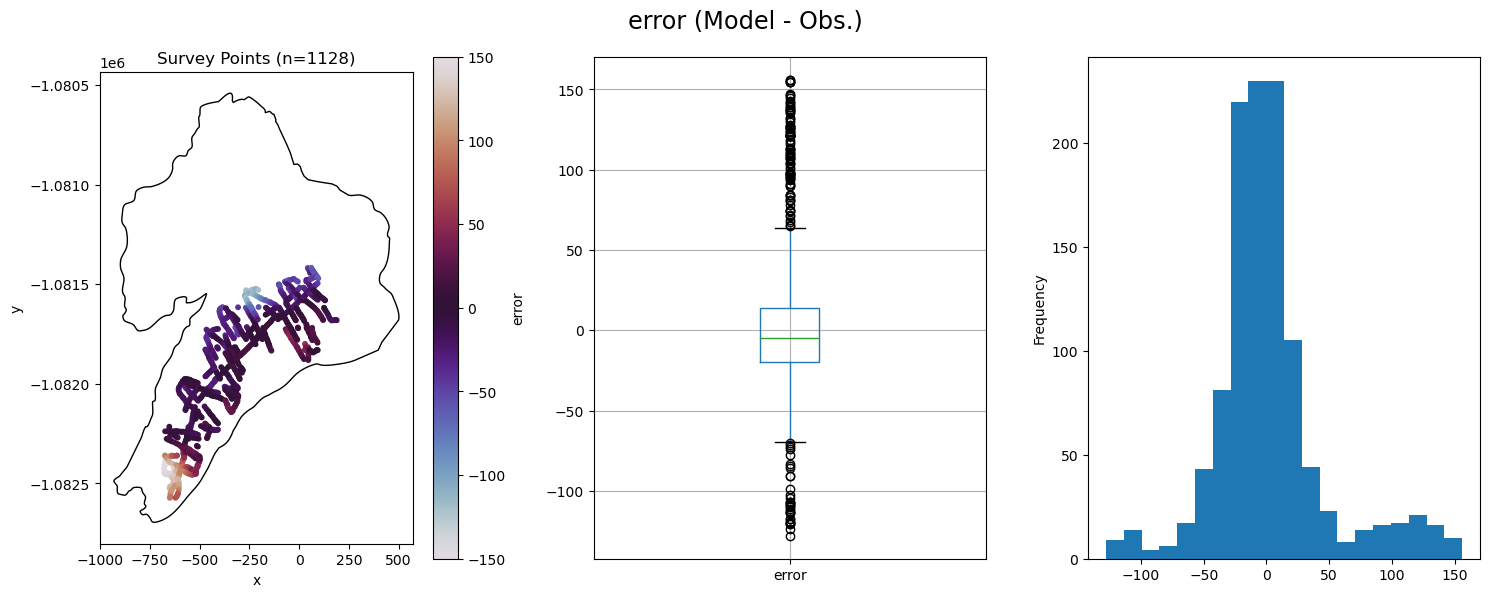

In [245]:
# View gridded variables
f, (ax,ax1,ax2) = plt.subplots(1,3,figsize=(15,6))
var='error'
f.suptitle(var+' (Model - Obs.)',fontsize='xx-large');
ax.set_title(f'Survey Points (n={len(df_Val)})')
error_Val[-1].plot.scatter(x='x', y='y', c=var, cmap='twilight', s=10, ax=ax,vmin=-150,vmax=150);
geom.plot(ax=ax, facecolor='none', edgecolor='k');
error_Val[-1].boxplot(var,ax=ax1)
error_Val[-1][var].plot.hist(bins=20,ax=ax2)
plt.tight_layout()

In [51]:
df_09.head()

,lat,lon,distance,profundida,geometry,min_x,max_x,min_y,max_y,x,y,thk_2008,thk_2008_mean_dist,thk_2008_error,thk_2008_abs_error
0,-9.791300,-77.249500,0.00,105.0,POINT (-77.24950 -9.79130),-77.249500,-77.249500,-9.791300,-9.791300,-624.298714,-1.082338e+06,90.646200,25.414084,-14.353800,14.353800
1,-9.791067,-77.249167,44.78,103.0,POINT (-77.24917 -9.79107),-77.249167,-77.249167,-9.791067,-9.791067,-587.780773,-1.082312e+06,88.873977,8.469742,-14.126023,14.126023
2,-9.787900,-77.247400,468.58,85.0,POINT (-77.24740 -9.78790),-77.247400,-77.247400,-9.787900,-9.787900,-394.006813,-1.081962e+06,83.814029,11.921973,-1.185971,1.185971
3,-9.787517,-77.247183,517.20,85.0,POINT (-77.24718 -9.78752),-77.247183,-77.247183,-9.787517,-9.787517,-370.209751,-1.081920e+06,86.143539,12.071068,1.143539,1.143539
4,-9.787267,-77.246850,563.07,85.0,POINT (-77.24685 -9.78727),-77.246850,-77.246850,-9.787267,-9.787267,-333.691236,-1.081892e+06,84.346879,8.529647,-0.653121,0.653121


In [52]:
# Interpolate Gridded Thickness to df_09
vn = 'param_Opt_A_dist_thk'
df_09[vn] = ds[vn].interp(x=('z', df_09.x), y=('z', df_09.y))
df_09['model_residual_error_A_Opt'] = df_09[vn] - df_09.profundida
# And plot


#### Model results are very close to 2009 thickness observations despite local error!
Mean thicknesses of points of observations are within 20cm accuracy!

In [53]:
df_09.param_Opt_A_dist_thk.mean(), df_09.profundida.mean(), df_09.model_residual_error_A_Opt.mean()

(96.13601348201466, 95.94117647058823, 0.19483701142643764)

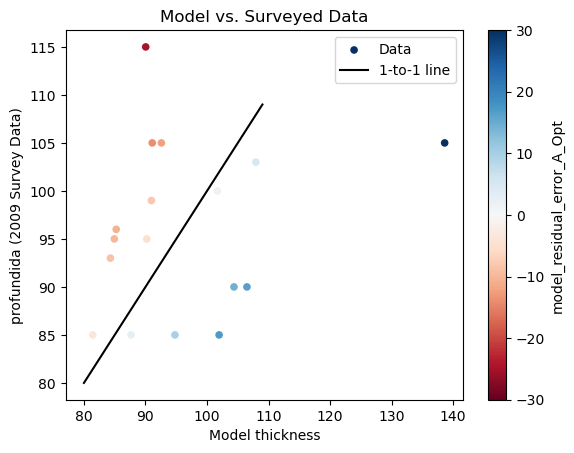

In [54]:
# and plot
f,ax=plt.subplots()
df_09.plot.scatter(x=vn,y='profundida',c='model_residual_error_A_Opt',cmap='RdBu',vmin=-30,vmax=30,label='Data',ax=ax)
ax.plot(np.arange(80,110),np.arange(80,110),color='k',label='1-to-1 line')
ax.legend();
ax.set_xlabel('Model thickness');
ax.set_ylabel('profundida (2009 Survey Data)');
ax.set_title(f'Model vs. Surveyed Data');

# 4] Frontal Ablation Calibration

#### Ice thickness Calibration is now complete. Prepare glacier for transient model runs:

In [176]:
# To Start Here
gdirs = workflow.init_glacier_directories(inventory[:1],reset=False, force=False)
gdir = gdirs[0]
gdir.get_diagnostics()

2024-03-28 11:58:50: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/oggm/utils/_funcs.py:546: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if 'Multi' in geometry.type:
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/oggm/utils/_funcs.py:573: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type != 'Polygon':
/home/tshutkin/miniconda3/envs/oggm_env/lib/python3.9/site-packages/oggm/utils/_workflow.py:2678: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for k, s in entity.iteritems():


{'dem_source': 'USER',
 'dem_needed_interpolation': True,
 'dem_invalid_perc': 0.026758908758647695,
 'dem_needed_extrapolation': True,
 'dem_extrapol_perc': 0.022320845842579297,
 'dem_invalid_perc_in_mask': 0.0,
 'n_orig_centerlines': 1,
 'flowline_type': 'centerlines',
 'perc_invalid_flowline': 0.0,
 'inversion_glen_a': 4.3156799999999994e-24,
 'inversion_fs': 0}

In [177]:
gdir.get_diagnostics()['inversion_glen_a']/2.4e-24

1.7981999999999998

#### Interlude: Impact of min slope filter...
need to re-run inversion calibration once I have access to lake bathymetry.

In [234]:
np.max((wl_cal - fls.bed_h))

149.4826479765252

2024-03-28 16:11:03: oggm.cfg: PARAMS['min_slope'] changed from `1.5` to `3.0`.
2024-03-28 16:11:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-03-28 16:11:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-03-28 16:11:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-03-28 16:11:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-03-28 16:11:03: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2024-03-28 16:11:04: oggm.cfg: PARAMS['min_slope'] changed from `3.0` to `3.5`.
2024-03-28 16:11:04: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-03-28 16:11:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-03-28 16:11:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-03-28 16:11:04: oggm.workflow: Execute entity tasks [filter_inversion_out

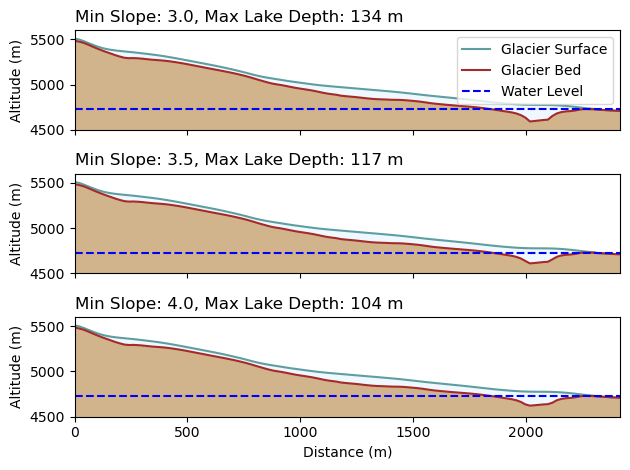

In [243]:
cfg.PARAMS['use_kcalving_for_inversion'] =False
f,axs=plt.subplots(3,1,sharex=True)
for i,min_slope in enumerate([3.,3.5,4.]):
    #cfg.PARAMS['min_slope_flowline_filter']=min_slope
    cfg.PARAMS['min_slope']=min_slope
    workflow.inversion_tasks([gdir], filter_inversion_output=True);
    workflow.execute_entity_task(tasks.init_present_time_glacier,[gdir])
    
    # PLot profile
    ax=axs[i]
    fls=gdir.read_pickle('model_flowlines')[0]

    ax.plot(fls.map_dx*fls.dis_on_line,fls.surface_h,color='cadetblue',label='Glacier Surface')
    ax.fill_between(x=fls.map_dx*fls.dis_on_line,y1=fls.surface_h,y2=fls.bed_h,color='aliceblue')
    ax.plot(fls.map_dx*fls.dis_on_line,fls.bed_h,color='brown', label='Glacier Bed')
    ax.fill_between(x=fls.map_dx*fls.dis_on_line,y1=fls.bed_h,y2=4500,color='tan')

    domain=fls.map_dx*fls.dis_on_line
    ax.set_xlim(domain[0],domain[-1])
    ax.set_ylim(4500,5600)

    wl_cal = 4727 # Water level remains consistent between 2008 and 2023, according to DEMs and outlines (see ArcPro data) 
    lake_depth = np.max((wl_cal - fls.bed_h))
    ax.axhline(wl_cal,linestyle='--',color='blue',label='Water Level')
    
    ax.set_title(f'Min Slope: {min_slope}, Max Lake Depth: {round(lake_depth)} m',loc='left');
    ax.set_ylabel('Altitude (m)');
    
axs[2].set_xlabel('Distance (m)');
axs[0].legend();
plt.tight_layout()
cfg.PARAMS['min_slope'] = 1.5

#### End Interlude

In [186]:
# First make sure to run inversion using Aopt
# Set model params to calibrated values
cfg.PARAMS['inversion_glen_a']= df_cand.A.mean() 
cfg.PARAMS['glen_a']= df_cand.A.mean() 
cfg.PARAMS['inversion_fs']=0
cfg.PARAMS['use_inversion_params_for_run']=True

# Run Final Inversion
cfg.PARAMS['use_kcalving_for_inversion'] =False
workflow.inversion_tasks([gdir], filter_inversion_output=True);
workflow.execute_entity_task(tasks.init_present_time_glacier,[gdir])
V_check = workflow.execute_entity_task(tasks.get_inversion_volume,[gdir])
assert V_check == ds.param_Opt_A_dist_thk.Volume



2024-03-28 12:01:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-03-28 12:01:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-03-28 12:01:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-03-28 12:01:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-03-28 12:01:22: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2024-03-28 12:01:22: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers


#### Assess MB Model

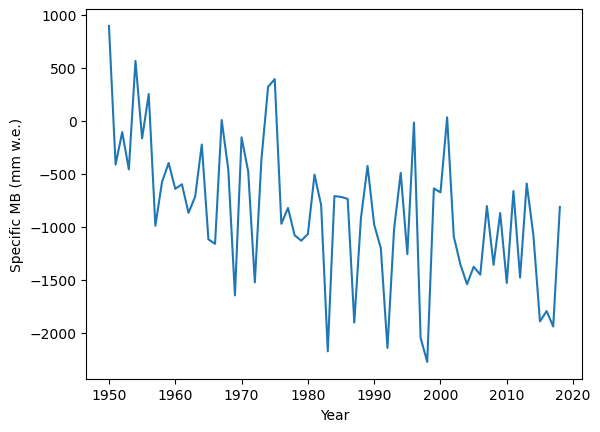

In [188]:
# Get the calibrated mass-balance model - the default is to use OGGM's "MonthlyTIModel"
mbmod = oggm.core.massbalance.MultipleFlowlineMassBalance(gdir)

# Compute the specific MB for this glacier
fls = gdir.read_pickle('model_flowlines')
years = np.arange(1950, 2019)
mb_ts = mbmod.get_specific_mb(fls=fls, year=years)

plt.plot(years, mb_ts);
plt.ylabel('Specific MB (mm w.e.)');
plt.xlabel('Year');

In [196]:
np.mean(np.array(mbs),axis=0)

array([ 1.54652181,  1.54652181,  1.54652181,  1.54652181,  1.54440058,
        1.53500139,  1.52278362,  1.5105139 ,  1.49795006,  1.48742851,
        1.47886208,  1.47125965,  1.46191535,  1.45166118,  1.44053771,
        1.42865589,  1.41648038,  1.40070432,  1.37608547,  1.34285108,
        1.30352625,  1.26112837,  1.21670839,  1.16980506,  1.1202853 ,
        1.07007714,  1.0191903 ,  0.96649713,  0.91195382,  0.85055512,
        0.78786672,  0.72329938,  0.65339002,  0.58045196,  0.48891724,
        0.35718215,  0.2113733 ,  0.05953752, -0.10118598, -0.26850142,
       -0.42979429, -0.57286928, -0.69955731, -0.81324195, -0.9152684 ,
       -1.01363313, -1.1159538 , -1.21709338, -1.31123756, -1.39960235,
       -1.48538737, -1.57052008, -1.65479691, -1.73622464, -1.81204219,
       -1.88005306, -1.94099494, -1.99764803, -2.05180789, -2.10529037,
       -2.15824628, -2.21085551, -2.26450237, -2.31876847, -2.37187528,
       -2.42344236, -2.47440479, -2.52544654, -2.57731187, -2.63

In [212]:
dfmbg.head()

,lon,lat,profundida,altura_sup,altura_Bed,x,y,i,j,surf_2008,delta_surf,mwe_per_year,low,high
surf_2008_bin,,,,,,,,,,,,,,
4770,-77.249409,-9.793330,15.868650,4734.550000,4718.681350,-614.297151,-1.082563e+06,41.000000,211.500000,4769.931337,-35.381337,-6.552099,-6.629853,-6.474346
4780,-77.249403,-9.792275,33.023740,4742.144143,4709.120403,-613.709824,-1.082446e+06,41.112150,200.074766,4773.516099,-31.371956,-5.809622,-6.476015,-5.143228
4790,-77.248833,-9.791423,41.899871,4753.148559,4711.248688,-551.189859,-1.082352e+06,47.387097,190.580645,4786.332914,-33.184356,-6.145251,-6.907871,-5.382631
4800,-77.249168,-9.790988,50.565139,4758.471271,4707.906133,-587.877184,-1.082304e+06,43.636364,185.818182,4794.258396,-35.787124,-6.627245,-7.240507,-6.013983
4810,-77.249301,-9.790513,63.223252,4773.865203,4710.641951,-602.496054,-1.082251e+06,42.166667,180.583333,4805.291166,-31.425964,-5.819623,-6.959921,-4.679325


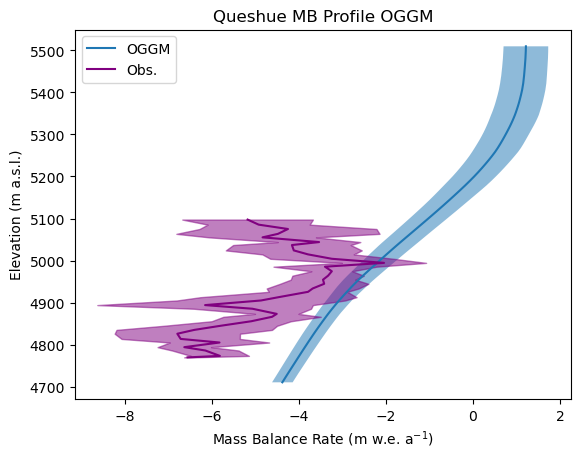

In [214]:
# Where the flowlines are:
mbs=[]
for year in np.arange(2008,2015):
    heights, widths, mb = mbmod.get_annual_mb_on_flowlines(fls, year=year)
    # units kg ice per second to m w.e. per year:
    mb = mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] / 1000
    mbs.append(mb)

# Plot
mb_mean=np.mean(np.array(mbs),axis=0)
mb_sigma=np.std(np.array(mbs),axis=0)

# OGGM
plt.plot(mb_mean, heights, '-', label='OGGM');
plt.fill_betweenx(y=heights,x1=mb_mean+mb_sigma,x2=mb_mean-mb_sigma,alpha=0.5)

# Observed Surface Hgt Change
plt.plot(dfmbg.mwe_per_year,dfmbg.surf_2008,color='purple',label='Obs.')
plt.fill_betweenx(y=dfmbg.surf_2008,x1=dfmbg.low,x2=dfmbg.high,alpha=0.5,color='purple')


# # Another year:
# heights, widths, mb = mbmod.get_annual_mb_on_flowlines(fls, year=2001)
# # units kg ice per second to mm w.e. per year:
# mb = mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] 
# Plot
#plt.plot(mb, heights, '-', label='2001');
plt.ylabel('Elevation (m a.s.l.)'); plt.xlabel('Mass Balance Rate (m w.e. a$^{-1}$)'); plt.legend();
plt.title('Queshue MB Profile OGGM');

In [218]:
np.deg2rad(cfg.PARAMS['min_slope'])

0.026179938779914945

##### Run Transient Model with Calving

In [23]:
cfg.PARAMS['use_kcalving_for_run']=True
gdir.is_tidewater=True
gdir.is_lake_terminating=True

2024-03-22 17:51:53: oggm.cfg: PARAMS['use_kcalving_for_run'] changed from `False` to `True`.


In [24]:
cfg.PARAMS['hydro_month_sh']= 1# Resolve hydro year ambiguity by using January as month 1..

wl_cal = 4727 #4731 # This is values used in version submitted to JG #4727 # Water level remains consistent between 2008 and 2023, according to DEMs and outlines (see ArcPro data) 
calving_ks=np.arange(0.9, 1.3, 0.1) #[1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.4] # Added 2.4 back in there
sufs=['_woc']
for kc in calving_ks[0:6]:
    suffix='_wc'+str(round(kc,2)).split('.')[0]+str(round(kc,2)).split('.')[-1]
    model = tasks.run_from_climate_data(gdir, ys=2008,water_level=wl_cal,calving_k=kc, 
                                        mb_elev_feedback='monthly', store_monthly_step=True,
                                        output_filesuffix=suffix);
    sufs.append(suffix)                           
    #models_wc.append(model)

sufs

['_woc', '_wc09', '_wc10', '_wc11', '_wc12']

In [279]:
# With Out Calving (WOC)
model = tasks.run_from_climate_data(gdir, ys=2008,water_level=wl_cal,calving_k=0, 
                                        mb_elev_feedback='monthly', store_monthly_step=True,
                                        output_filesuffix='_woc');

In [307]:
da
# elas=model.mb_model.get_ela(year=)
# plt.plot(years,elas);

<xarray.DataArray (y: 235, x: 163)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float32 -1.08e+06 -1.08e+06 -1.08e+06 ... -1.083e+06 -1.083e+06
  * x        (x) float32 -1.025e+03 -1.015e+03 -1.005e+03 ... 575.0 585.0 595.0
Attributes:
    name:         Opt_A
    Creep:        4.3156799999999994e-24
    Volume:       82761803.20716305
    description:  Distributed thickness predicted by OGGM (Model run suffix: ...
    units:        meters

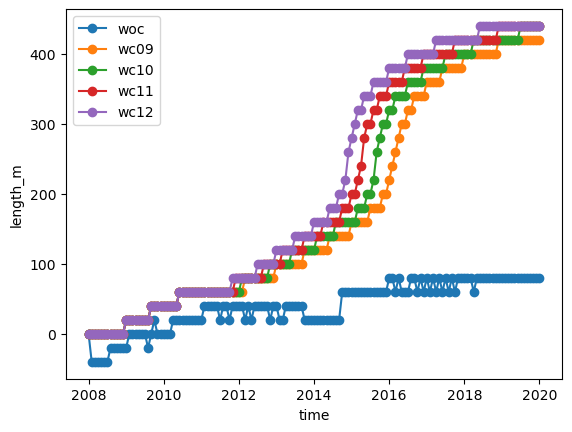

In [393]:
f,ax=plt.subplots()
for suf in sufs:
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        retreat = ds.length_m.isel(time=0) - ds.length_m
        retreat.plot(marker="o",label=suf[1:],ax=ax)
ax.legend();


In [87]:
ds

<xarray.Dataset>
Dimensions:           (time: 145)
Coordinates:
  * time              (time) float64 2.008e+03 2.008e+03 ... 2.02e+03 2.02e+03
    hydro_year        (time) int64 ...
    hydro_month       (time) int64 ...
    calendar_year     (time) int64 ...
    calendar_month    (time) int64 ...
Data variables:
    volume_m3         (time) float64 ...
    volume_bsl_m3     (time) float64 ...
    volume_bwl_m3     (time) float64 ...
    area_m2           (time) float64 ...
    length_m          (time) float64 ...
    calving_m3        (time) float64 ...
    calving_rate_myr  (time) float64 ...
Attributes:
    description:          OGGM model output
    oggm_version:         1.5.3
    calendar:             365-day no leap
    creation_date:        2024-03-21 14:53:46
    water_level:          4727
    glen_a:               4.3156799999999994e-24
    fs:                   0
    mb_model_class:       MultipleFlowlineMassBalance
    mb_model_hemisphere:  sh

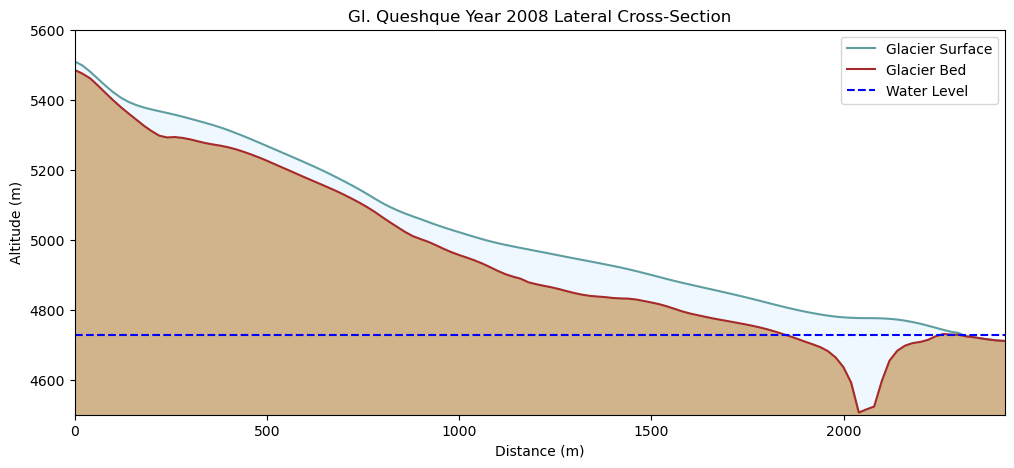

In [407]:
fls=gdir.read_pickle('model_flowlines')[0]
lake_depth = wl_cal - fls.bed_h
f,ax=plt.subplots(figsize=(12, 5))
ax.plot(fls.map_dx*fls.dis_on_line,fls.surface_h,color='cadetblue',label='Glacier Surface')
ax.fill_between(x=fls.map_dx*fls.dis_on_line,y1=fls.surface_h,y2=fls.bed_h,color='aliceblue')
ax.plot(fls.map_dx*fls.dis_on_line,fls.bed_h,color='brown', label='Glacier Bed')
ax.fill_between(x=fls.map_dx*fls.dis_on_line,y1=fls.bed_h,y2=4500,color='tan')

domain=fls.map_dx*fls.dis_on_line
ax.set_xlim(domain[0],domain[-1])
ax.set_ylim(4500,5600)

wl_cal = 4727 # Water level remains consistent between 2008 and 2023, according to DEMs and outlines (see ArcPro data) 
ax.axhline(wl_cal,linestyle='--',color='blue',label='Water Level')
ax.legend();
ax.set_title('Gl. Queshque Year 2008 Lateral Cross-Section');
ax.set_ylabel('Altitude (m)');
ax.set_xlabel('Distance (m)');

In [78]:
depth =[]
for d in lake_depth.tolist():
    if d < 0:
        d=0
    depth.append(d)
    
depth = np.array(depth)

In [80]:
depth

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [82]:
lake = np.array([2.62388679,  10.13657689,  18.19330646,
            25.78128035,  33.89826742,  45.58297759,  63.6348299 ,
            91.07318266, 135.15667863, 220.73194843, 211.75166143,
              203.51076081, 130.4702082 ,  72.38988223,  44.38993904,
            29.8459821 ,  22.34102507,  19.07495556,  13.17100114,
             2.88863735]) 
lake.mean()

69.8323494025

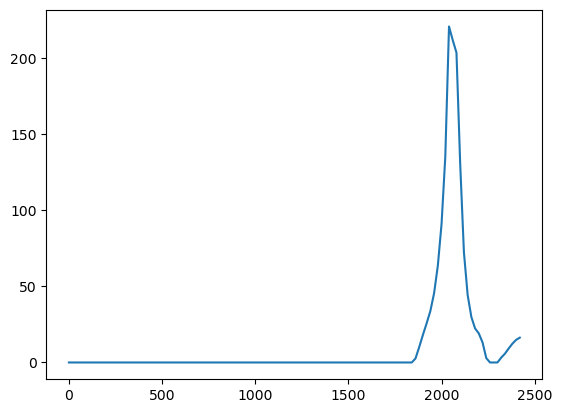

In [79]:
plt.plot(fls.map_dx*fls.dis_on_line,depth)

In [194]:
gdir.read_pickle('climate_info')

{'baseline_climate_source': 'CRU TS4.04',
 'baseline_hydro_yr_0': 1901,
 'baseline_hydro_yr_1': 2019,
 'mb_calib_params': {'temp_default_gradient': -0.0065,
  'temp_all_solid': 0.0,
  'temp_all_liq': 2.0,
  'temp_melt': -1.0,
  'prcp_scaling_factor': 2.5,
  'climate_qc_months': 3,
  'hydro_month_nh': 10,
  'hydro_month_sh': 1}}

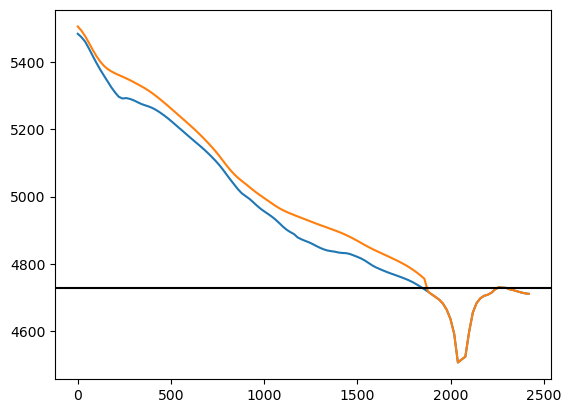

In [175]:
mfl = model.fls[0]
plt.plot(mfl.map_dx*mfl.dis_on_line,mfl.bed_h)
plt.plot(mfl.map_dx*mfl.dis_on_line,mfl.surface_h)
plt.axhline(wl_cal,color='k')

In [136]:
model = tasks.run_from_climate_data(gdir, ys=2008,water_level=wl_cal,calving_k=kc, 
                                    mb_elev_feedback='annual', store_monthly_step=False,
                                    output_filesuffix=suffix);

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for suf in sufs:
    if suf == '_woc':
        with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
            ds.volume_m3.isel(time=slice(0, 12)).plot(ax=ax1, label=suf[1:]);
            ds.calving_rate_myr.isel(time=slice(0, 12)).plot(ax=ax2, label=suf[1:]);
    else:
        with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
            ds.volume_m3.isel(time=slice(0, 12)).plot(ax=ax1, label=suf[1:]);
            ds.calving_rate_myr.isel(time=slice(0, 12)).plot(ax=ax2, label=suf[-2]+'.'+suf[-1]);
ax2.legend(title='Calving k [a$^-$$^1$]');

# h1=ax1.scatter(2019,v_epoch3,marker='*',c='k',s=50, zorder=7); 
# h2=ax1.scatter(2015,v_epoch2,marker='o',c='k',s=50,zorder=7);
# ax1.scatter(2009,v_epoch1,marker='o',c='k',s=50,zorder=7);
# ax1.vlines(2015,v_epoch2_range[0],v_epoch2_range[-1],colors=['k'],zorder=7);
# ax1.vlines(2009,Vs[0],Vs[-1],colors=['k']);
# ax2.legend(title='Calving Rate Parameter (a$^-$$^1$)');
# ax1.legend([h1,h2], ['Image-based volume estimate','GPR-based volume estimate']);

ax1.set_ylabel('Volume (m$^3$)'); ax1.set_xlabel('Hydrological Year');
ax2.set_ylabel('Calving rate (m a$^{-1}$)'); ax2.set_xlabel('Hydrological Year');
plt.suptitle(f'Calving Sensitivity to k Parameter: water level = {wl_cal}m'); 

##### Examine calving validation data

<Axes: xlabel='x', ylabel='y'>

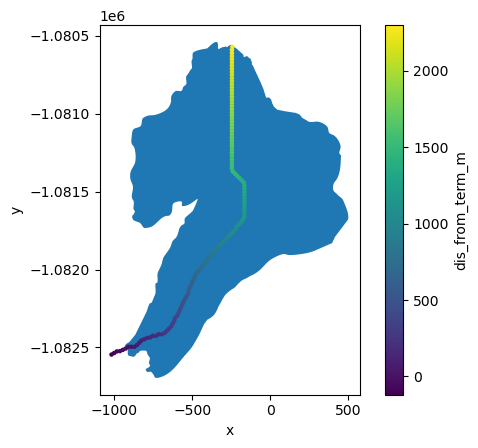

In [97]:
fls=gdir.read_pickle('model_flowlines')[0]
df_fls = pd.DataFrame()
df_fls['lon']=fls.point_lons
df_fls['lat']=fls.point_lats
# Reproject data to local glacier grid projection
xx, yy = salem.transform_proj(salem.wgs84, gdir.grid.proj, df_fls['lon'].values, df_fls['lat'].values)
df_fls['x'] = xx
df_fls['y'] = yy
df_fls['thick']=fls.thick
df_fls['dis_m']=fls.dis_on_line * fls.map_dx # I am not confident this is correctly calculated

# Calculate distance from terminus - this will give linear retreat rate along flowline
dis_at_term = df_fls.iloc[fls.terminus_index].dis_m
df_fls['dis_from_term_m'] = dis_at_term - df_fls.dis_m

f,ax=plt.subplots()
geom =gdir.read_shapefile('outlines')
geom.plot(ax=ax)
df_fls.plot.scatter(x='x',y='y',c='dis_from_term_m',s=5,ax=ax)

/tmp/ipykernel_164/4021960728.py:46: RuntimeWarning: invalid value encountered in divide
  dd_per_yr = np.array(dd)/np.array(dt)


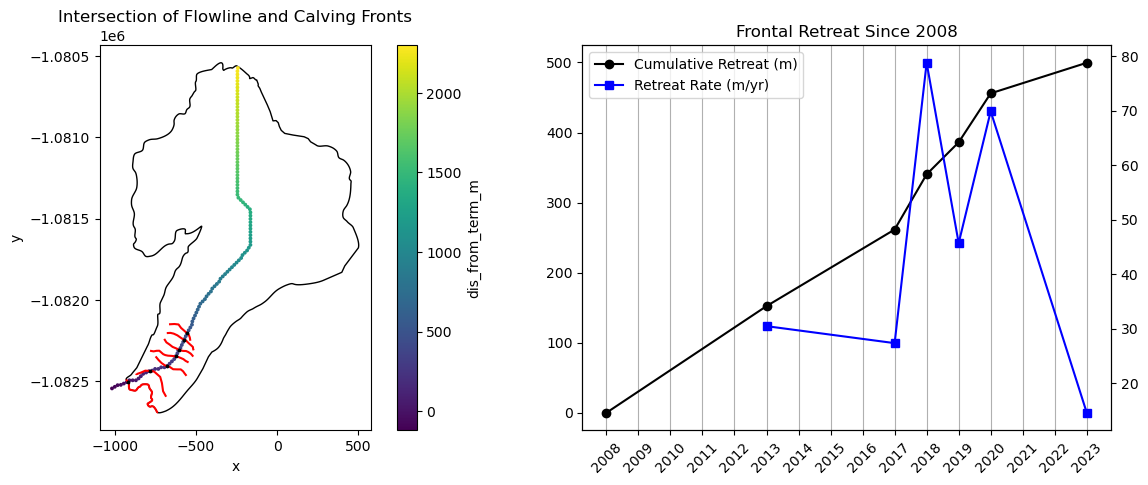

In [100]:
# Get flowline geometry #
#########################

# if using algorithm based fls
fl = shapely.LineString([ll for ll in zip(df_fls.x.values,df_fls.y.values)]) 
# Otherwise: use altered fls with more practical terminus
# fl_alt_path = OUTPUTS+'/Queshque_flowlines_altered.shp'
# fl=gpd.read_file(fl_alt_path).to_crs(gdir.grid.proj.crs).geometry[0]

# Get calving fronts
path = '/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/QQ_OGGM/MapData/Queshque_Manual_outlines/Sentinel-2/'
fronts = gpd.read_file(path+'CalvingFronts.shp').to_crs(gdir.grid.proj.crs)
fronts.sort_values(by='Year',inplace=True)
dt=[fronts.Year.values[i]-fronts.Year.values[i-1] for i in range(len(fronts))] # time (yrs) between each traced calving front
dt[0]=0 # for year 2008

f,(ax,ax1)=plt.subplots(1,2,figsize=(15,5))
geom.plot(ax=ax,edgecolor='k',facecolor='none')
df_fls.plot.scatter(x='x',y='y',c='dis_from_term_m',s=3,ax=ax)

fronts.plot(ax=ax,color='r')

dd=[]
yrs=[]
#p=df_fls.iloc[fls.terminus_index]
p = shapely.intersection(fronts.iloc[0].geometry,fl) # begin form 2008 front where it intersets with flowline
#ax1.scatter(2008,0,color='blue')
ax1.set_xticks(np.arange(2008,2024),labels=np.arange(2008,2024),rotation=45)
ax1.grid(axis='x')
ax1.set_title('Frontal Retreat Since 2008')
for i in range(len(fronts)):
    yr = fronts.iloc[i].Year
    yrs.append(yr)
    pp = shapely.intersection(fronts.iloc[i].geometry,fl)
    ax.scatter(x=pp.x,y=pp.y,color='k',s=3,zorder=10)
    
    # Linear retreat from terminus position
    #d = distance(df_fls.iloc[fls.terminus_index],pp) # This is linear distance from terminus...not dist along flowline
    #ax1.scatter(yr,d,color='k')
    # Now cumulative distance from previous point - Linear distance from previous front position
    dd.append(distance(p,pp))
    p=pp # start from next point
    
dd_cum = np.cumsum(dd)  
h1=ax1.plot(yrs,dd_cum,marker='o',color='k',label='Cumulative Retreat (m)')
dd_per_yr = np.array(dd)/np.array(dt)

ax2=ax1.twinx()
h2=ax2.plot(yrs,dd_per_yr,color='blue',marker='s',label='Retreat Rate (m/yr)')
ax1.legend(handles=[h1[0],h2[0]],labels=[h1[0].get_label(),h2[0].get_label()],loc='upper left')
# ax2.legend()
    

# Plot Terminus
#df_fls.iloc[fls.terminus_index:fls.terminus_index+1].plot.scatter(x='x',y='y',ax=ax)
ax.set_title('Intersection of Flowline and Calving Fronts');
# # Get Intersection
# shapely.intersection(f0,fl).xy

#### Same as above but using altered flowline geometry to better reflect position of calving front
this poses issues because the auto fls do not intersect with the correct position on the calving front. See how the retreat rate decreases betweeen 2013 and 2017 above, but remains fairly consistent below

/tmp/ipykernel_66/4170817161.py:48: RuntimeWarning: invalid value encountered in divide
  dd_per_yr = np.array(dd)/np.array(dt)


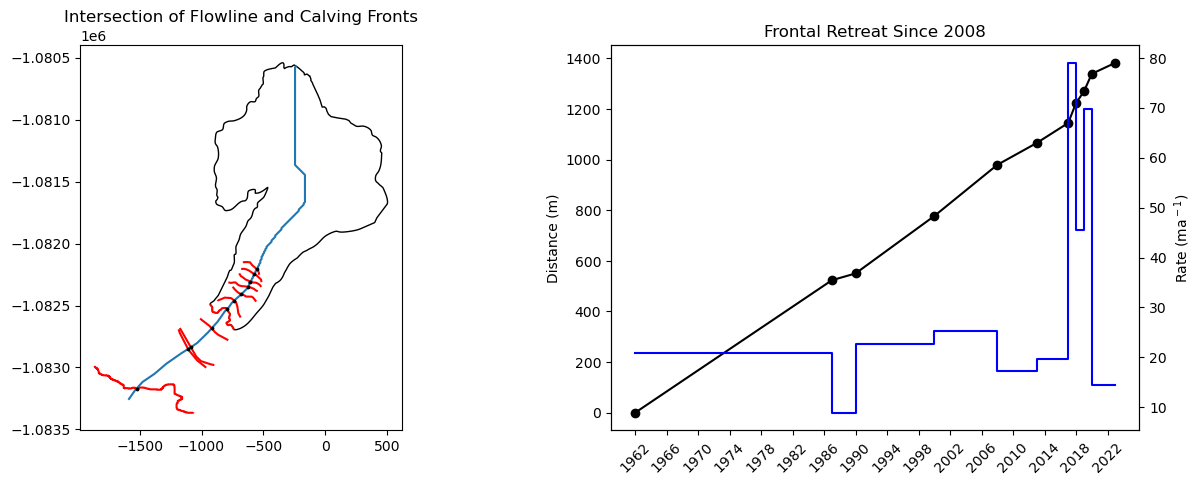

In [28]:
# Get flowline geometry #
#########################

# if using algorithm based fls
#fl = shapely.LineString([ll for ll in zip(df_fls.x.values,df_fls.y.values)]) 
# Otherwise: use altered fls with more practical terminus
fl_alt_path = OUTPUTS+'/Queshque_flowlines_altered_1962.shp'
fl=gpd.read_file(fl_alt_path).to_crs(gdir.grid.proj.crs).geometry[0]
geom =gdir.read_shapefile('outlines')

# Get calving fronts
path = '/mnt/c/Users/shutkin.3/OneDrive - The Ohio State University/QQ_OGGM/MapData/Queshque_Manual_outlines/Sentinel-2/'
fronts = gpd.read_file(path+'CalvingFronts.shp').to_crs(gdir.grid.proj.crs)
fronts.sort_values(by='Year',inplace=True)
dt=[fronts.Year.values[i]-fronts.Year.values[i-1] for i in range(len(fronts))] # time (yrs) between each traced calving front
dt[0]=0 # for year 2008

f,(ax,ax1)=plt.subplots(1,2,figsize=(15,5))
geom.plot(ax=ax,edgecolor='k',facecolor='none')
#df_fls.plot.scatter(x='x',y='y',c='dis_from_term_m',s=3,ax=ax)
gpd.read_file(fl_alt_path).to_crs(gdir.grid.proj.crs).plot(ax=ax)

fronts.plot(ax=ax,color='r')

dd=[]
yrs=[]
#p=df_fls.iloc[fls.terminus_index]
p = shapely.intersection(fronts.iloc[0].geometry,fl) # begin form 2008 front where it intersets with flowline
#ax1.scatter(2008,0,color='blue')
ax1.set_xticks(np.arange(1962,2024,4),labels=np.arange(1962,2024,4),rotation=45)

ax1.set_title('Frontal Retreat Since 2008')
for i in range(len(fronts)):
    yr = fronts.iloc[i].Year
    yrs.append(yr)
    pp = shapely.intersection(fronts.iloc[i].geometry,fl)
    ax.scatter(x=pp.x,y=pp.y,color='k',s=3,zorder=10)
    
    # Linear retreat from terminus position
    #d = distance(df_fls.iloc[fls.terminus_index],pp) # This is linear distance from terminus...not dist along flowline
    #ax1.scatter(yr,d,color='k')
    # Now cumulative distance from previous point - Linear distance from previous front position
    dd.append(distance(p,pp))
    p=pp # start from next point
    
dd_cum = np.cumsum(dd)  
h1=ax1.plot(yrs,dd_cum,marker='o',color='k',label='Cum. Obs. Retreat (m)')
dd_per_yr = np.array(dd)/np.array(dt)

ax2=ax1.twinx()
h2=ax2.step(yrs,dd_per_yr,color='blue',marker='none',label='Retreat Rate (ma$^-$$^1$)')
#ax1.legend(handles=[h1[0],h2[0]],labels=[h1[0].get_label(),h2[0].get_label()],loc='upper left')
ax1.set_ylabel('Distance (m)');
ax2.set_ylabel('Rate (ma$^-$$^1$)');
# ax2.legend()
    

# Plot Terminus
#df_fls.iloc[fls.terminus_index:fls.terminus_index+1].plot.scatter(x='x',y='y',ax=ax)
ax.set_title('Intersection of Flowline and Calving Fronts');
# # Get Intersection
# shapely.intersection(f0,fl).xy

In [17]:
yrs, dd_cum

([1962, 1987, 1990, 2000, 2008, 2013, 2017, 2018, 2019, 2020, 2023],
 array([   0.        ,  523.43003808,  550.1804877 ,  776.85750858,
         978.9897534 , 1065.13495929, 1144.16995332, 1223.17488528,
        1268.63191697, 1338.41161565, 1382.02153947]))

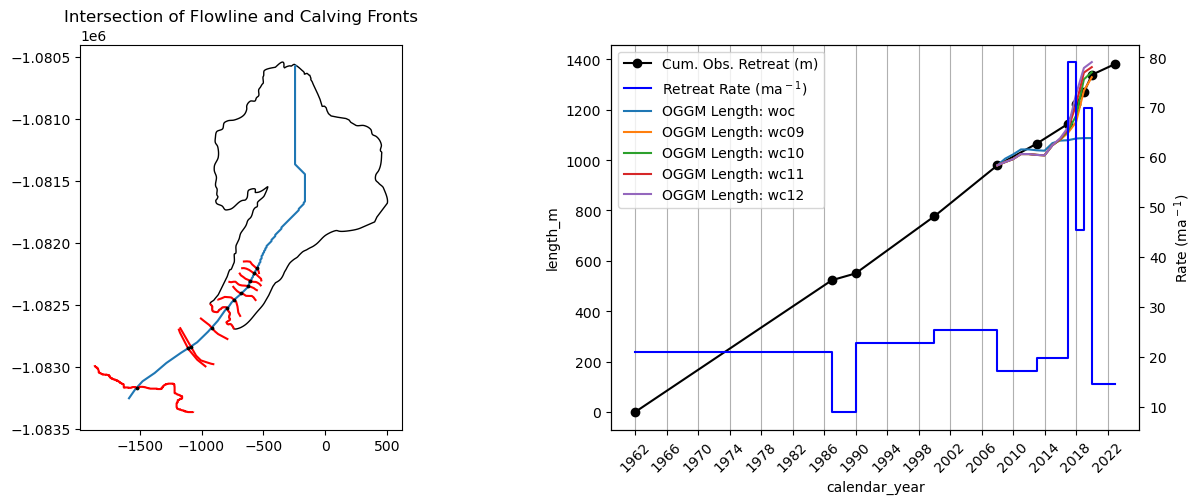

In [31]:
hh=[]
ll=[]
for suf in ['_woc', '_wc09', '_wc10', '_wc11', '_wc12']:
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        ds = ds.groupby('calendar_year').mean()
        retreat = ds.length_m.isel(calendar_year=0) - ds.length_m + dd_cum[4] # add distance at 2008 to correct values
        h = retreat.plot(label='OGGM Length: '+suf[1:],ax=ax1)
        hh.append(h[0])
        ll.append(h[0].get_label())
        # Calving
#         h = ds.calving_rate_myr.plot(linestyle='--',label='OGGM Calving: '+suf[1:],ax=ax2,zorder=0)
#         hh.append(h[0])
#         ll.append(h[0].get_label())
        
ax1.legend(handles=[h1[0],h2[0]]+hh,
           labels=[h1[0].get_label(),h2[0].get_label()]+ll,
           loc='upper left');
ax1.grid(axis='x')
ax1.set_title('')
f

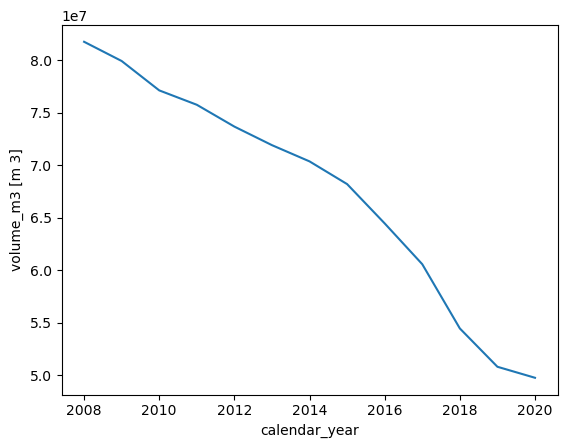

In [33]:
ds.volume_m3.plot()#.groupby('calendar_year').mean()

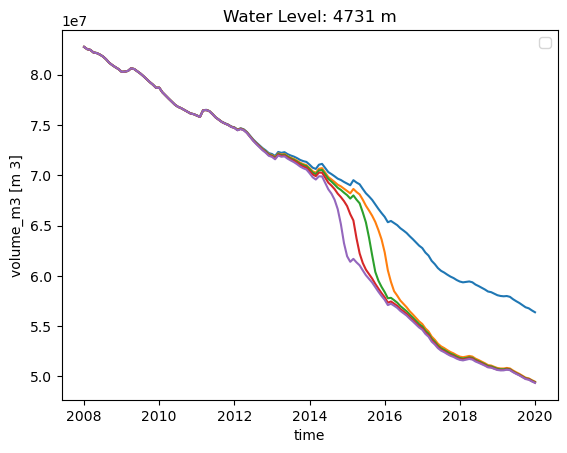

In [404]:
f,ax=plt.subplots()
for suf in sufs:
    with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=suf)) as ds:
        #ds.groupby('calendar_year').mean().volume_m3.plot(ax=ax,label=suf[1:]); #
        ds.volume_m3.plot(ax=ax)
ax.set_title('Water Level: '+str(ds.attrs['water_level'])+" m")        
ax.legend();

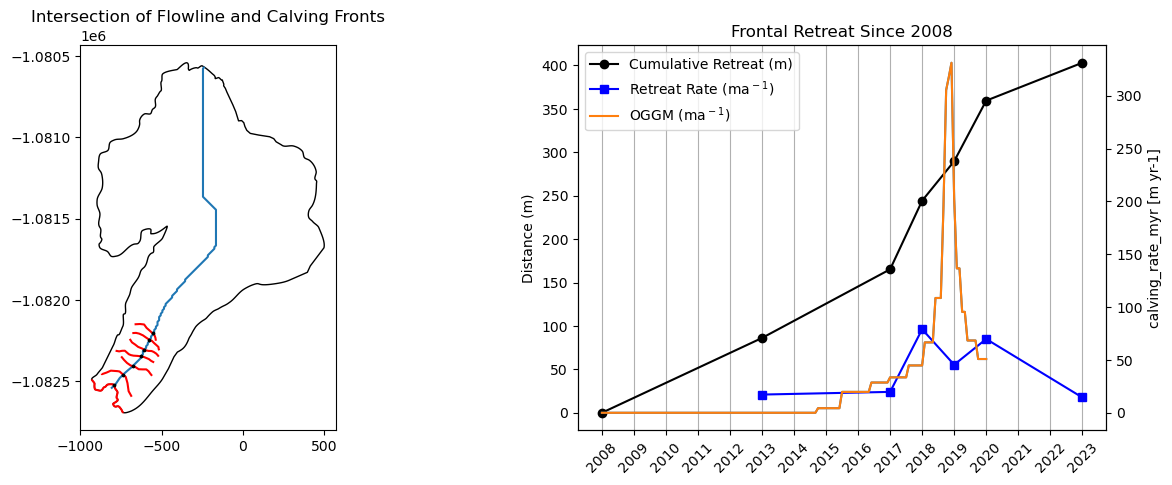

In [136]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics',filesuffix=sufs[2])) as ds:
    h3=ds.calving_rate_myr.plot(label='OGGM'+' (ma$^-$$^1$)',ax=ax2)
ax1.legend(handles=[h1[0],h2[0],h3[0]],labels=[h1[0].get_label(),h2[0].get_label(),h3[0].get_label()],loc='upper left')

f

#### Frontal retreat plot provides data against which to compare simualted calving model
Addition of earlier calving fronts will be necessary to get a better picture of linear retreat rate

#### Mass Balance

In [1]:
# Take a look at climate dataset (temp anomolies)
da = xr.open_dataset(gdir.get_filepath('climate_historical')).sel(time=slice('1945-01-01','2019-12-01')).temp
da_anom = da.groupby('time.month') - da.sel(time=slice('1980-01-01','2010-12-01')).groupby('time.month').mean()
da_anom.plot();

NameError: name 'xr' is not defined

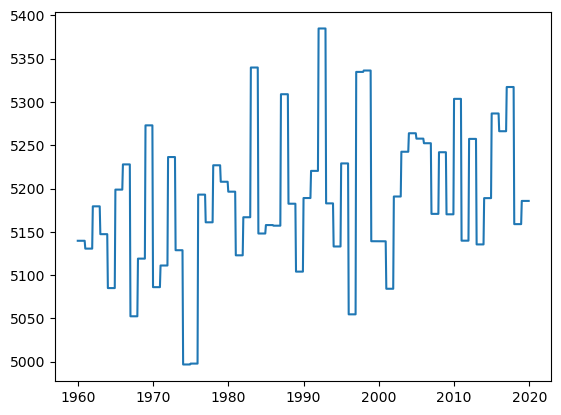

In [362]:
#
#utils.date_to_floatyear(m=12,y=1961)
dates = np.array([utils.date_to_floatyear(m=m,y=y) for y in np.arange(1960,2020) for m in np.arange(1,13)])
years=np.arange(1960,2020)
elas = model.mb_model.get_ela(year=dates)
plt.plot(dates,elas);

# Scraps Below!

In [33]:
# # Produce distributed thickness maps by iterating through parameters. Reults are stored in RAM on an xarray dataset
# # and must be written to disk as netCDF

# n=4 # number of model iterations
# default_glen_a=2.4e-24
# glen_as = [2.4e-24*f for f in np.linspace(1.5,2.5,n)] # Parameter spread

# V=[] # store volumes here
# with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds: # Get dimensions from glacier directory
#     for i,a in enumerate(glen_as):
#         i=str(i)
#         if len(i)==1:
#             i='0'+i
#         da, v= map_dist_thk(gdir, glen_a=a, fs=None, varname_suffix=i)
#         ds.update({f'dist_thick_{i}':da})
#         V.append(v)
        
# plt.plot(np.array(glen_as)/default_glen_a,V);
# plt.xlabel('A-Factor');
# plt.ylabel('Glacier Volume (m$^3$)');

In [ ]:
# f,axs=plt.subplots(1,2,sharey=True)
# for n,i in enumerate(['00','01']):
#     ds[f'dist_thick_{i}'].plot(ax=axs[n],vmin=0,vmax=200,cmap='Blues')

In [36]:
# Test if inversion works
# update_dist_thk(gdir, varname_suffix='testing', plot=True);

In [109]:
# cfg.PARAMS['use_kcalving_for_inversion'] =False
# default_glen_a=2.4e-24
# var = 'thk_2008' # calibrate against derived thickness measurements
# fs=0
# glen_as = [2.4e-24*f for f in np.linspace(1.5,2.5,20)] # List of A_values to be used
# reshuffle = 2 # Number of times to shuffle calibration data

# start_time = time.time()
# total_runs = (len(glen_as)*reshuffle) + reshuffle
# print('Total Runs:',total_runs)

# with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    
#     with cf.ProcessPoolExecutor() as ex:
#         results = [ex.submit(Creep_Cal, gdir, glen_as, df_agg, ds, var) for n in range(reshuffle)]
        
# outputs = np.array([r.result() for r in results])

# # Values to store for analysis
# # optA_candidates = [] # List of potential optA values
# # testing_ME = []
# # testing_MAE = []
# # testing_RMSE = [] # List of errors associated with each optimal parameter candidate run over testing dataset
# # testing_V = [] # modeled volumes
# # testing_h = [] # modeled mean thicknesses


# # candidate = As[training_MAE.index(min(training_MAE))] # Take parameter value for lowest error across training dataset
# # optA_candidates.append(candidate)
# # da,volume = map_dist_thk(gdir, ds=ds, glen_a=candidate, fs=None, varname_suffix=f'candidate_{count}')

# # testing_V.append(volume)
# # RMSE,MAE,ME = error_eval(da, TEST, var) # evaluate error against testing dataset
# # testing_ME.append(ME)
# # testing_MAE.append(MAE)
# # testing_RMSE.append(RMSE)

# print("--- %s seconds ---" % (time.time() - start_time))
# #outputs

Total Runs: 42


2024-02-28 22:14:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 22:14:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 22:14:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 22:14:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 22:14:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 22:14:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 22:14:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-02-28 22:14:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-02-28 22:14:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 22:14:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 22:14:35: oggm.workflow: Applying global task i

2024-02-28 22:14:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 22:14:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 22:14:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 22:14:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-02-28 22:14:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 22:14:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-02-28 22:14:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 22:14:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 22:14:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 22:14:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 22:14:43: oggm.workflow: Execute entity t

EOFError: Ran out of input

In [108]:
results[1].result()

(4.8631578947368414e-24,
 2.026315789473684,
 41.830597012994,
 28.276742641762073,
 -1.8306933209579537,
 81027033.96594515)

In [114]:
start_time = time.time()
glen_as = [2.4e-24*f for f in np.linspace(1.5,2.5,10)] # List of A_values to be used
Creep_Cal(gdir, glen_as, df_agg, ds, 'thk_2008')
print("--- %s seconds ---" % (time.time() - start_time))

2024-02-28 22:23:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 22:23:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 22:23:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 22:23:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-02-28 22:23:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 22:23:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 22:23:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 22:23:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-02-28 22:23:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 22:23:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 22:23:08: oggm.workflow: Execute entity tasks [

--- 8.047053575515747 seconds ---


In [113]:
dd = (4.989473684210526e-24,
         2.0789473684210527,
         41.748442002785815,
         28.32869989451293,
         -2.2654526124415817,
         80624043.15612395)
np.array(dd)

array([ 4.98947368e-24,  2.07894737e+00,  4.17484420e+01,  2.83286999e+01,
       -2.26545261e+00,  8.06240432e+07])

In [65]:
i = list(outputs[1][1]).index(outputs[1][1].min())
outputs[1][0][i]

5.3999999999999994e-24

In [ ]:
candidate = As[training_MAE.index(min(training_MAE))] # Take parameter value for lowest error across training dataset
optA_candidates.append(candidate)
volume, thickness_m = inversion_model_run(gdir, glen_a=candidate, fs=0, best=False, file_suffix=None)
testing_V.append(volume)
testing_h.append(thickness_m)

count+=1
print(count,'of',total_runs,f'complete. Candidate A-Factor tested: {round(candidate/default_glen_a,3)}')
ME,MAE,RMSE = GC.error_eval(TEST, var, gdir, return_df=False) # evaluate error against testing dataset
testing_ME.append(ME)
testing_MAE.append(MAE)
testing_RMSE.append(RMSE)

In [38]:
cfg.PARAMS['use_kcalving_for_inversion'] =False
default_glen_a=2.4e-24
var = 'thk_2008' # calibrate against derived thickness measurements
fs=0
glen_as = [2.4e-24*f for f in np.linspace(1.5,2.5,20)] # List of A_values to be used
reshuffle = 10 # Number of times to shuffle calibration data

all_coords = df_agg.index.to_list() # Get unique coord pairs

# Cal_coords=all_coords# Val_coords = train_test_split(all_coords,test_size=0) # Divide into Cal and Val indices CHANGE TO 70-30 split?
# Cal = df_agg.loc[Cal_coords] # Select Calibration Dataset - these are the GPR points used throughout the procedure
#Val = df_agg.loc[Val_coords] # Select Validation Dataaser - save for final uncertainty estimation

# Values to store for analysis
optA_candidates = [] # List of potential optA values
testing_ME = []
testing_MAE = []
testing_RMSE = [] # List of errors associated with each optimal parameter candidate run over testing dataset
testing_V = [] # modeled volumes
testing_h = [] # modeled mean thicknesses

count = 0 # begin counting model runs
total_runs = (len(glen_as)*reshuffle) + reshuffle

start_time = time.time()

with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    
    for i in range(reshuffle): # however many iterations we want to use. Pelto uses 50
        TRAIN_coords, TEST_coords = train_test_split(all_coords,test_size=0.5)
        TRAIN = df_agg.loc[TRAIN_coords]
        TEST = df_agg.loc[TEST_coords]

        As=[] 
        training_MAE = []

        for A in glen_as:
            try:
                da,v = map_dist_thk(gdir, ds=ds, glen_a=A, fs=None, varname_suffix='')
                MAE = error_eval(da, TRAIN, var)[1]
                count+=1
                print(count,'of',total_runs,'complete.')
                if np.isnan(MAE)==True:
                    break
                As.append(A)
                training_MAE.append(MAE)
            except ValueError:
                count+=1
                print(f'Run {count} failed!')


    #     for A in glen_as:
    #         try:
    #             inversion_model_run(gdir, glen_a=A, fs=0, best=False)# Always negelect sliding, use local function instead ('inversion_run()')
    #             MAE = GC.error_eval(TRAIN, var, gdir, return_df=False)[1]
    #             count+=1
    #             print(count,'of',total_runs,'complete.')
    #             if np.isnan(MAE)==True:
    #                 break
    #             As.append(A)
    #             training_MAE.append(MAE)
    #         except:
    #             count+=1
    #             print(f'Run {count} failed!')
    #             #pass


        candidate = As[training_MAE.index(min(training_MAE))] # Take parameter value for lowest error across training dataset
        optA_candidates.append(candidate)
        da,volume = map_dist_thk(gdir, ds=ds, glen_a=candidate, fs=None, varname_suffix=f'candidate_{count}')

        testing_V.append(volume)

        count+=1
        print(count,'of',total_runs,f'complete. Candidate A-Factor tested: {round(candidate/default_glen_a,3)}')
        RMSE,MAE,ME = error_eval(da, TEST, var) # evaluate error against testing dataset
        testing_ME.append(ME)
        testing_MAE.append(MAE)
        testing_RMSE.append(RMSE)

        candidate = As[training_MAE.index(min(training_MAE))] # Take parameter value for lowest error across training dataset
        optA_candidates.append(candidate)
        volume, thickness_m = inversion_model_run(gdir, glen_a=candidate, fs=0, best=False, file_suffix=None)
        testing_V.append(volume)
        testing_h.append(thickness_m)

        count+=1
        print(count,'of',total_runs,f'complete. Candidate A-Factor tested: {round(candidate/default_glen_a,3)}')
        ME,MAE,RMSE = GC.error_eval(TEST, var, gdir, return_df=False) # evaluate error against testing dataset
        testing_ME.append(ME)
        testing_MAE.append(MAE)
        testing_RMSE.append(RMSE)

print("--- %s seconds ---" % (time.time() - start_time))

2024-02-28 16:42:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-02-28 16:42:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


1 of 210 complete.


2024-02-28 16:42:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


2 of 210 complete.


2024-02-28 16:42:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


3 of 210 complete.


2024-02-28 16:42:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


4 of 210 complete.


2024-02-28 16:42:27: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:27: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:27: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:27: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


5 of 210 complete.


2024-02-28 16:42:28: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:28: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:28: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:28: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


6 of 210 complete.


2024-02-28 16:42:29: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:29: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:29: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:29: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


7 of 210 complete.


2024-02-28 16:42:29: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:29: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:29: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:30: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


8 of 210 complete.


2024-02-28 16:42:30: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:30: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:30: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:30: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


9 of 210 complete.


2024-02-28 16:42:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


10 of 210 complete.


2024-02-28 16:42:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


11 of 210 complete.


2024-02-28 16:42:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


12 of 210 complete.


2024-02-28 16:42:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


13 of 210 complete.


2024-02-28 16:42:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


14 of 210 complete.


2024-02-28 16:42:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


15 of 210 complete.


2024-02-28 16:42:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


16 of 210 complete.


2024-02-28 16:42:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


17 of 210 complete.


2024-02-28 16:42:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


18 of 210 complete.


2024-02-28 16:42:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


19 of 210 complete.


2024-02-28 16:42:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


20 of 210 complete.


2024-02-28 16:42:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


21 of 210 complete. Candidate A-Factor tested: 1.868


2024-02-28 16:42:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


22 of 210 complete.


2024-02-28 16:42:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


23 of 210 complete.


2024-02-28 16:42:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


24 of 210 complete.


2024-02-28 16:42:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


25 of 210 complete.


2024-02-28 16:42:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


26 of 210 complete.


2024-02-28 16:42:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


27 of 210 complete.


2024-02-28 16:42:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


28 of 210 complete.


2024-02-28 16:42:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


29 of 210 complete.


2024-02-28 16:42:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


30 of 210 complete.


2024-02-28 16:42:51: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:51: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:51: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


31 of 210 complete.


2024-02-28 16:42:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


32 of 210 complete.


2024-02-28 16:42:53: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:53: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:53: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


33 of 210 complete.


2024-02-28 16:42:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:54: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:54: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


34 of 210 complete.


2024-02-28 16:42:55: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:55: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:55: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:55: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


35 of 210 complete.


2024-02-28 16:42:56: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:56: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:56: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:56: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


36 of 210 complete.


2024-02-28 16:42:57: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:57: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:57: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:57: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


37 of 210 complete.


2024-02-28 16:42:58: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:58: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:58: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:58: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


38 of 210 complete.


2024-02-28 16:42:59: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:42:59: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:42:59: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:42:59: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


39 of 210 complete.


2024-02-28 16:43:00: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:00: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:00: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:00: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


40 of 210 complete.


2024-02-28 16:43:00: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:00: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


41 of 210 complete.


2024-02-28 16:43:01: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:01: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


42 of 210 complete. Candidate A-Factor tested: 1.921


2024-02-28 16:43:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


43 of 210 complete.


2024-02-28 16:43:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


44 of 210 complete.


2024-02-28 16:43:04: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


45 of 210 complete.


2024-02-28 16:43:05: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:05: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:05: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:05: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


46 of 210 complete.


2024-02-28 16:43:06: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:06: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:06: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


47 of 210 complete.


2024-02-28 16:43:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


48 of 210 complete.


2024-02-28 16:43:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


49 of 210 complete.


2024-02-28 16:43:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


50 of 210 complete.


2024-02-28 16:43:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


51 of 210 complete.


2024-02-28 16:43:11: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:11: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


52 of 210 complete.


2024-02-28 16:43:12: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:12: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:12: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:12: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


53 of 210 complete.


2024-02-28 16:43:13: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:13: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:13: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:13: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


54 of 210 complete.


2024-02-28 16:43:14: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:14: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:14: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:14: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


55 of 210 complete.


2024-02-28 16:43:15: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:15: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:15: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:15: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


56 of 210 complete.


2024-02-28 16:43:16: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:16: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:16: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:16: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


57 of 210 complete.


2024-02-28 16:43:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


58 of 210 complete.


2024-02-28 16:43:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


59 of 210 complete.


2024-02-28 16:43:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


60 of 210 complete.


2024-02-28 16:43:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


61 of 210 complete.


2024-02-28 16:43:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


62 of 210 complete.


2024-02-28 16:43:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


63 of 210 complete. Candidate A-Factor tested: 2.132


2024-02-28 16:43:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


64 of 210 complete.


2024-02-28 16:43:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


65 of 210 complete.


2024-02-28 16:43:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


66 of 210 complete.


2024-02-28 16:43:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


67 of 210 complete.


2024-02-28 16:43:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


68 of 210 complete.


2024-02-28 16:43:27: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:27: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:27: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:27: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


69 of 210 complete.


2024-02-28 16:43:28: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:28: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:28: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:28: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


70 of 210 complete.


2024-02-28 16:43:29: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:29: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:29: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:29: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


71 of 210 complete.


2024-02-28 16:43:30: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:30: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:30: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:30: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


72 of 210 complete.


2024-02-28 16:43:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


73 of 210 complete.


2024-02-28 16:43:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


74 of 210 complete.


2024-02-28 16:43:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


75 of 210 complete.


2024-02-28 16:43:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


76 of 210 complete.


2024-02-28 16:43:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


77 of 210 complete.


2024-02-28 16:43:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


78 of 210 complete.


2024-02-28 16:43:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


79 of 210 complete.


2024-02-28 16:43:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


80 of 210 complete.


2024-02-28 16:43:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


81 of 210 complete.


2024-02-28 16:43:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers


82 of 210 complete.


2024-02-28 16:43:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2024-02-28 16:43:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


83 of 210 complete.


2024-02-28 16:43:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


84 of 210 complete. Candidate A-Factor tested: 1.816


2024-02-28 16:43:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


85 of 210 complete.


2024-02-28 16:43:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


86 of 210 complete.


2024-02-28 16:43:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


87 of 210 complete.


2024-02-28 16:43:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


88 of 210 complete.


2024-02-28 16:43:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


89 of 210 complete.


2024-02-28 16:43:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


90 of 210 complete.


2024-02-28 16:43:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


91 of 210 complete.


2024-02-28 16:43:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


92 of 210 complete.


2024-02-28 16:43:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


93 of 210 complete.


2024-02-28 16:43:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


94 of 210 complete.


2024-02-28 16:43:51: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:51: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:51: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


95 of 210 complete.


2024-02-28 16:43:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


96 of 210 complete.


2024-02-28 16:43:53: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:53: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:53: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


97 of 210 complete.


2024-02-28 16:43:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:54: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:54: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


98 of 210 complete.


2024-02-28 16:43:55: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:55: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:55: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:55: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


99 of 210 complete.


2024-02-28 16:43:56: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:56: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:56: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:56: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


100 of 210 complete.


2024-02-28 16:43:56: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:56: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:56: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:56: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


101 of 210 complete.


2024-02-28 16:43:57: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:57: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:57: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:57: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


102 of 210 complete.


2024-02-28 16:43:58: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:58: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:58: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:58: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


103 of 210 complete.


2024-02-28 16:43:59: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:43:59: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:43:59: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:43:59: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


104 of 210 complete.


2024-02-28 16:44:00: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:00: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:00: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:00: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


105 of 210 complete. Candidate A-Factor tested: 1.816


2024-02-28 16:44:01: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:01: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


106 of 210 complete.


2024-02-28 16:44:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:02: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


107 of 210 complete.


2024-02-28 16:44:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


108 of 210 complete.


2024-02-28 16:44:04: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


109 of 210 complete.


2024-02-28 16:44:05: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:05: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:05: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:05: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


110 of 210 complete.


2024-02-28 16:44:05: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:05: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:05: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


111 of 210 complete.


2024-02-28 16:44:06: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:06: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:06: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


112 of 210 complete.


2024-02-28 16:44:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


113 of 210 complete.


2024-02-28 16:44:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


114 of 210 complete.


2024-02-28 16:44:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


115 of 210 complete.


2024-02-28 16:44:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


116 of 210 complete.


2024-02-28 16:44:11: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:11: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


117 of 210 complete.


2024-02-28 16:44:12: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:12: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:12: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:12: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


118 of 210 complete.


2024-02-28 16:44:13: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:13: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:13: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:13: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


119 of 210 complete.


2024-02-28 16:44:14: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:14: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:14: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:14: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


120 of 210 complete.


2024-02-28 16:44:15: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:15: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:15: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:15: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


121 of 210 complete.


2024-02-28 16:44:15: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:15: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:15: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:16: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


122 of 210 complete.


2024-02-28 16:44:16: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:16: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:16: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:16: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


123 of 210 complete.


2024-02-28 16:44:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


124 of 210 complete.


2024-02-28 16:44:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


125 of 210 complete.


2024-02-28 16:44:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


126 of 210 complete. Candidate A-Factor tested: 1.711


2024-02-28 16:44:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


127 of 210 complete.


2024-02-28 16:44:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


128 of 210 complete.


2024-02-28 16:44:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


129 of 210 complete.


2024-02-28 16:44:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


130 of 210 complete.


2024-02-28 16:44:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


131 of 210 complete.


2024-02-28 16:44:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


132 of 210 complete.


2024-02-28 16:44:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


133 of 210 complete.


2024-02-28 16:44:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


134 of 210 complete.


2024-02-28 16:44:27: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:27: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:27: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:27: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


135 of 210 complete.


2024-02-28 16:44:28: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:28: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:28: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:28: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


136 of 210 complete.


2024-02-28 16:44:29: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:29: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:29: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:29: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


137 of 210 complete.


2024-02-28 16:44:30: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:30: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:30: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:30: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


138 of 210 complete.


2024-02-28 16:44:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


139 of 210 complete.


2024-02-28 16:44:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


140 of 210 complete.


2024-02-28 16:44:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


141 of 210 complete.


2024-02-28 16:44:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


142 of 210 complete.


2024-02-28 16:44:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


143 of 210 complete.


2024-02-28 16:44:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


144 of 210 complete.


2024-02-28 16:44:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


145 of 210 complete.


2024-02-28 16:44:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


146 of 210 complete.


2024-02-28 16:44:39: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:39: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:39: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:39: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


147 of 210 complete. Candidate A-Factor tested: 1.868


2024-02-28 16:44:40: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:40: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:40: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:40: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


148 of 210 complete.


2024-02-28 16:44:41: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:41: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:41: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:41: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


149 of 210 complete.


2024-02-28 16:44:42: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:42: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:42: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:42: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


150 of 210 complete.


2024-02-28 16:44:43: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:43: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:43: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:43: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


151 of 210 complete.


2024-02-28 16:44:44: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:44: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:44: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:44: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


152 of 210 complete.


2024-02-28 16:44:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:45: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:45: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:45: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


153 of 210 complete.


2024-02-28 16:44:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:46: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:46: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:46: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


154 of 210 complete.


2024-02-28 16:44:47: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:47: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:47: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:47: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


155 of 210 complete.


2024-02-28 16:44:48: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:48: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:48: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:48: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


156 of 210 complete.


2024-02-28 16:44:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:49: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:49: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:49: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


157 of 210 complete.


2024-02-28 16:44:50: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:50: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:50: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:50: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


158 of 210 complete.


2024-02-28 16:44:51: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:51: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:51: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:51: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


159 of 210 complete.


2024-02-28 16:44:52: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:52: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:52: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:52: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


160 of 210 complete.


2024-02-28 16:44:53: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:53: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:53: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:53: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


161 of 210 complete.


2024-02-28 16:44:54: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:54: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:54: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:54: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


162 of 210 complete.


2024-02-28 16:44:55: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:55: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:55: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:55: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


163 of 210 complete.


2024-02-28 16:44:55: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:55: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:55: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:56: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


164 of 210 complete.


2024-02-28 16:44:56: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:56: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:56: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:57: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


165 of 210 complete.


2024-02-28 16:44:57: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:57: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:57: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:57: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


166 of 210 complete.


2024-02-28 16:44:58: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:58: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:58: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:58: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


167 of 210 complete.


2024-02-28 16:44:59: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:44:59: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:44:59: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:44:59: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


168 of 210 complete. Candidate A-Factor tested: 1.763


2024-02-28 16:45:00: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:00: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:00: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:00: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


169 of 210 complete.


2024-02-28 16:45:01: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:01: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:01: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:01: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


170 of 210 complete.


2024-02-28 16:45:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:02: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:02: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:02: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


171 of 210 complete.


2024-02-28 16:45:03: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:03: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:03: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:03: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


172 of 210 complete.


2024-02-28 16:45:04: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:04: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:04: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:04: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


173 of 210 complete.


2024-02-28 16:45:05: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:05: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:05: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:06: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


174 of 210 complete.


2024-02-28 16:45:06: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:06: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:06: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


175 of 210 complete.


2024-02-28 16:45:07: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:07: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:07: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:07: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


176 of 210 complete.


2024-02-28 16:45:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


177 of 210 complete.


2024-02-28 16:45:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


178 of 210 complete.


2024-02-28 16:45:10: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:10: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:10: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:10: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


179 of 210 complete.


2024-02-28 16:45:11: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:11: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:11: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:11: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


180 of 210 complete.


2024-02-28 16:45:12: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:12: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:12: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:12: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


181 of 210 complete.


2024-02-28 16:45:13: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:13: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:13: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:13: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


182 of 210 complete.


2024-02-28 16:45:14: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:14: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:14: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:14: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


183 of 210 complete.


2024-02-28 16:45:15: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:15: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:15: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:15: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


184 of 210 complete.


2024-02-28 16:45:16: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:16: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:16: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:16: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


185 of 210 complete.


2024-02-28 16:45:17: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:17: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:17: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:17: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


186 of 210 complete.


2024-02-28 16:45:18: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:18: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:18: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:18: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


187 of 210 complete.


2024-02-28 16:45:19: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:19: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:19: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:19: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


188 of 210 complete.


2024-02-28 16:45:20: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:20: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:20: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:20: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


189 of 210 complete. Candidate A-Factor tested: 2.079


2024-02-28 16:45:21: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:21: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:21: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:21: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


190 of 210 complete.


2024-02-28 16:45:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:22: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:22: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


191 of 210 complete.


2024-02-28 16:45:22: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:22: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


192 of 210 complete.


2024-02-28 16:45:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:23: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:23: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:23: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


193 of 210 complete.


2024-02-28 16:45:24: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:24: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:24: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:24: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


194 of 210 complete.


2024-02-28 16:45:25: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:25: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:25: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:25: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


195 of 210 complete.


2024-02-28 16:45:26: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:26: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:26: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:26: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


196 of 210 complete.


2024-02-28 16:45:27: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:27: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:27: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:27: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


197 of 210 complete.


2024-02-28 16:45:28: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:28: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:28: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:28: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


198 of 210 complete.


2024-02-28 16:45:29: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:29: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:29: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:29: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


199 of 210 complete.


2024-02-28 16:45:30: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:30: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:30: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:30: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


200 of 210 complete.


2024-02-28 16:45:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


201 of 210 complete.


2024-02-28 16:45:32: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:32: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:32: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:32: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


202 of 210 complete.


2024-02-28 16:45:33: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:33: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:33: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:33: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


203 of 210 complete.


2024-02-28 16:45:34: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:34: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:34: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:34: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


204 of 210 complete.


2024-02-28 16:45:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:35: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


205 of 210 complete.


2024-02-28 16:45:35: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:35: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:35: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


206 of 210 complete.


2024-02-28 16:45:36: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:36: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:36: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:36: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


207 of 210 complete.


2024-02-28 16:45:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:37: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:37: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:37: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


208 of 210 complete.


2024-02-28 16:45:38: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2024-02-28 16:45:38: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2024-02-28 16:45:38: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2024-02-28 16:45:38: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers


209 of 210 complete.
210 of 210 complete. Candidate A-Factor tested: 1.711
--- 196.92403554916382 seconds ---


In [50]:
outputs[0]

array([[3.60000000e-24, 4.20000000e-24, 4.80000000e-24, 5.40000000e-24,
        6.00000000e-24],
       [2.98654012e+01, 2.96288878e+01, 2.95563090e+01, 2.95635310e+01,
        2.96616889e+01]])

In [39]:
#Candidate parameter table
df_cand = pd.DataFrame()
df_cand['Glen_A']=optA_candidates
df_cand['A_factor']=np.array(optA_candidates)/default_glen_a
df_cand['Volume_km3']=testing_V
#df_cand['Thickness_mean']=testing_h
df_cand['ME'] = testing_ME
df_cand['MAE'] = testing_MAE
df_cand['RMSE'] = testing_RMSE

#df_cand.to_csv(OUTPUTS+f'inversion_candidate_parameters_thk_08.csv')
df_cand

,Glen_A,A_factor,Volume_km3,ME,MAE,RMSE
0,4.484211e-24,1.868421,8.214779e+07,1.253237,29.380836,43.985090
1,4.610526e-24,1.921053,8.170530e+07,-0.663180,29.543368,43.789434
2,5.115789e-24,2.131579,8.023300e+07,-2.795163,28.075146,42.259559
3,4.357895e-24,1.815789,8.260536e+07,-0.366404,27.887357,42.038487
4,4.357895e-24,1.815789,8.260536e+07,0.899988,29.860128,45.658439
5,4.105263e-24,1.710526,8.356970e+07,2.936152,31.028683,46.642033
6,4.484211e-24,1.868421,8.214779e+07,-0.277649,29.412196,43.006638
7,4.231579e-24,1.763158,8.307897e+07,2.918201,29.897937,45.323038
8,4.989474e-24,2.078947,8.062404e+07,-3.689254,27.290990,39.725042
9,4.105263e-24,1.710526,8.356970e+07,2.917595,29.913189,45.248994


In [41]:
glen_as

[3.6e-24,
 3.726315789473684e-24,
 3.852631578947368e-24,
 3.978947368421052e-24,
 4.1052631578947365e-24,
 4.231578947368421e-24,
 4.357894736842105e-24,
 4.484210526315789e-24,
 4.6105263157894736e-24,
 4.736842105263157e-24,
 4.8631578947368414e-24,
 4.989473684210526e-24,
 5.115789473684211e-24,
 5.242105263157894e-24,
 5.3684210526315785e-24,
 5.4947368421052635e-24,
 5.621052631578947e-24,
 5.7473684210526306e-24,
 5.873684210526315e-24,
 5.999999999999999e-24]

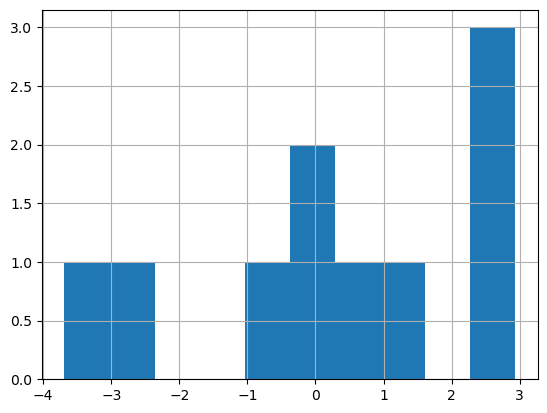

In [42]:
df_cand.ME.hist();

#### Final Inversion Using Calibrated Params

In [ ]:
A_opt = df_cand.Glen_A.mean()
A_mindf_cand.Glen_A.std()

### Now Validate Against Validation Data
#### 1] Val dataset from derived ice thickness
#### 2] Observed (2009) data - Hypothesis:  Should be slightly thinner (positive model bias)?

In [78]:
# Aggregate to Gridcell resolution
df_Val = aggregate_gpr_data_clip(gdir, Val, plot=False) # Input Val data for aggregation
geom =gdir.read_shapefile('outlines')
# and plot it
f, ax = plt.subplots()
df_Val.plot.scatter(x='x', y='y', c='altura_Bed', cmap='terrain', s=10, ax=ax);
geom.plot(ax=ax, facecolor='none', edgecolor='k');
ax.set_title(f'Reduced GPR Dataset Bed Topo\n(n={len(df_agg)})');

<xarray.Dataset>
Dimensions:          (x: 163, y: 235)
Coordinates:
  * x                (x) float32 -1.025e+03 -1.015e+03 ... 585.0 595.0
  * y                (y) float32 -1.08e+06 -1.08e+06 ... -1.083e+06 -1.083e+06
Data variables:
    topo             (y, x) float32 ...
    topo_smoothed    (y, x) float32 ...
    topo_valid_mask  (y, x) int8 ...
    glacier_mask     (y, x) int8 ...
    glacier_ext      (y, x) int8 ...
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=-77.2438072054302 +k=0.9996 +...
    max_h_dem:      5676.505
    min_h_dem:      4700.0156
    max_h_glacier:  5537.354
    min_h_glacier:  4718.337